# Jupyter Notebook: ged_analysis.ipynb

## 1. Import necessary libraries

In [1]:
import sys

!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install ipywidgets

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# Now import ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## 2. Define utility functions (for loading, cleaning, computing metrics)

In [2]:
def load_approx_results(file_path, fill_n_density=None):
    df = pd.read_excel(file_path)
    df.dropna(how='all', inplace=True)

    # Convert graph IDs to string to ensure consistent dtype
    df['graph_id_1'] = df['graph_id_1'].astype(str)
    df['graph_id_2'] = df['graph_id_2'].astype(str)

    numeric_cols = [
        'ged', 'accuracy', 'absolute_error', 'squared_error',
        'runtime', 'memory_usage_mb',
        'graph1_n', 'graph1_density', 'graph2_n', 'graph2_density'
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    if fill_n_density is not None:
        # Ensure fill DataFrame also has string-based IDs
        fill_n_density['graph_id_1'] = fill_n_density['graph_id_1'].astype(str)
        fill_n_density['graph_id_2'] = fill_n_density['graph_id_2'].astype(str)

        needed_cols = ['graph1_n', 'graph2_n', 'graph1_density', 'graph2_density']
        ref_cols = ['graph_id_1', 'graph_id_2'] + needed_cols
        ref = fill_n_density[ref_cols].drop_duplicates()

        merged = pd.merge(
            df, ref,
            how='left',
            on=['graph_id_1','graph_id_2'],
            suffixes=('', '_ref')
        )
        for c in needed_cols:
            merged[c] = np.where(
                merged[c].isna(),
                merged[f"{c}_ref"],
                merged[c]
            )
        drop_cols = [f"{c}_ref" for c in needed_cols if f"{c}_ref" in merged.columns]
        merged.drop(columns=drop_cols, inplace=True)
        df = merged

    df.dropna(subset=['graph_id_1','graph_id_2'], inplace=True)
    return df

def load_exact_results(file_path):
    """
    Load exact GED results from an XLSX file.
    Compute 'ged_exact' as the median of (min_ged, max_ged) if they differ,
    else min_ged (or max_ged).
    """
    df = pd.read_excel(file_path)
    df.dropna(how='all', inplace=True)

    # Convert graph IDs to string
    df['graph_id_1'] = df['graph_id_1'].astype(str)
    df['graph_id_2'] = df['graph_id_2'].astype(str)

    for col in ['min_ged', 'max_ged']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    def compute_ged_exact(row):
        if pd.notnull(row['min_ged']) and pd.notnull(row['max_ged']) and row['min_ged'] != row['max_ged']:
            return (row['min_ged'] + row['max_ged']) / 2.0
        else:
            return row['min_ged']  # or row['max_ged']

    df['ged_exact'] = df.apply(compute_ged_exact, axis=1)
    df.dropna(subset=['graph_id_1','graph_id_2','ged_exact'], inplace=True)
    return df

def compute_relative_accuracy(ged_approx, ged_exact):
    if ged_exact == 0 or ged_approx is None or ged_exact is None:
        return np.nan
    elif ged_approx >= (ged_exact * 2):
        return 0
    return 1 - abs(ged_approx - ged_exact)/ged_exact

## 3. Define file paths for each dataset & method

In [3]:
datasets = {
    "AIDS": {
        "HED":      r"C:\project_data\results\gedlib\AIDS\AIDS_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\AIDS\AIDS_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\AIDS\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\AIDS\merged\results.xlsx"
    },
    "IMDB-BINARY": {
        "HED":      r"C:\project_data\results\gedlib\IMDB-BINARY\IMDB-BINARY_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\IMDB-BINARY\IMDB-BINARY_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\IMDB-BINARY\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\IMDB-BINARY\merged\results.xlsx"
    },
    "PROTEINS": {
        "HED":      r"C:\project_data\results\gedlib\PROTEINS\PROTEINS_HED_results.xlsx",
        "IPFP":     r"C:\project_data\results\gedlib\PROTEINS\PROTEINS_IPFP_results.xlsx",
        "SimGNN":   r"C:\project_data\results\neural\PROTEINS\performance.xlsx",
        "Exact":    r"C:\project_data\results\exact_ged\PROTEINS\merged\results.xlsx"
    }
}

## 4. Load data for each dataset & method

In [4]:
def adjust_ids(df):
    # Convert id columns to integer, add one, then back to string
    for col in ['graph_id_1', 'graph_id_2']:
        df[col] = df[col].astype(int) - 1
        df[col] = df[col].astype(str)
    return df

data = {}

for dset, paths in datasets.items():
    df_simgnn = load_approx_results(paths["SimGNN"])
    df_exact  = load_exact_results(paths["Exact"])

    df_hed  = load_approx_results(paths["HED"], fill_n_density=df_simgnn)
    df_ipfp = load_approx_results(paths["IPFP"], fill_n_density=df_simgnn)

    # Adjust ids for HED and IPFP so that they start from 1.
    df_exact_copy = df_exact.copy()
    df_exact = adjust_ids(df_exact)

    # For consistency, fill SimGNN from itself:
    df_simgnn_filled = load_approx_results(paths["SimGNN"], fill_n_density=df_simgnn)

    # Merge approximate with exact (intersection in memory)
    df_hed  = pd.merge(df_hed,  df_exact, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))
    df_ipfp = pd.merge(df_ipfp, df_exact, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))
    df_simgnn_filled = pd.merge(df_simgnn_filled, df_exact_copy, on=['graph_id_1','graph_id_2'], how='inner', suffixes=('', '_exact'))

    # Compute metrics
    for df_approx in [df_hed, df_ipfp, df_simgnn_filled]:
        if 'ged_exact' in df_approx.columns and 'ged' in df_approx.columns:
            df_approx['absolute_error'] = abs(df_approx['ged'] - df_approx['ged_exact'])
            df_approx['squared_error']  = (df_approx['ged'] - df_approx['ged_exact'])**2
            df_approx['accuracy'] = df_approx.apply(
                lambda row: compute_relative_accuracy(row['ged'], row['ged_exact'])
                            if pd.notnull(row['ged_exact']) else np.nan,
                axis=1
            )
            df_approx['graph_size'] = (df_approx['graph1_n'] + df_approx['graph2_n']) / 2.0
            df_approx['graph_density'] = (df_approx['graph1_density'] + df_approx['graph2_density']) / 2.0

    data[dset] = {
        "HED":    df_hed,
        "IPFP":   df_ipfp,
        "SimGNN": df_simgnn_filled,
        "Exact": df_exact
    }

## 5. Generate correlation plots for each dataset

In [5]:
from scipy.stats import gaussian_kde

def filter_valid_accuracy(df):
    """
    Example helper to keep only rows with accuracy > 0 (if desired).
    If you want all rows (including zero or negative?), remove this filter.
    """
    return df[df['accuracy'] > 0]

def filter_common_pairs(dset):
    """
    Returns a dictionary with filtered DataFrames for each method (HED, IPFP, SimGNN)
    containing only the common graph pairs (i.e. rows where (graph_id_1, graph_id_2) appear in all three methods).
    """
    methods = ["HED", "IPFP", "SimGNN"]
    common_pairs = None
    for method in methods:
        df_method = data[dset][method]
        pairs = set(zip(df_method["graph_id_1"], df_method["graph_id_2"]))
        if common_pairs is None:
            common_pairs = pairs
        else:
            common_pairs = common_pairs.intersection(pairs)
    filtered = {}
    for method in methods:
        df_method = data[dset][method]
        filtered[method] = df_method[df_method.apply(lambda row: (row["graph_id_1"], row["graph_id_2"]) in common_pairs, axis=1)]
    return filtered


## Function to Plot Accuracy Density by Graph Size for Each Method

In [6]:
import pandas as pd

def get_df_with_simgnn_size(dset, method):
    # Retrieve the data for the chosen method
    df_method = data[dset][method].copy()
    # Retrieve SimGNN data that contains graph_size values
    df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_size"]]
    # Merge the two DataFrames on 'graph_id_1' and 'graph_id_2'
    df_merged = pd.merge(df_method, df_simgnn,
                         on=["graph_id_1", "graph_id_2"],
                         how="left",
                         suffixes=("", "_simgnn"))
    # Replace the 'graph_size' from the original with the SimGNN's value
    df_merged["graph_size"] = df_merged["graph_size_simgnn"]
    return df_merged

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

def plot_accuracy_hist_by_size_per_algorithm(dset):
    """
    For the given dataset name dset, create one set of 3 plots per algorithm (HED, IPFP, SimGNN)
    showing the overall density curve of relative accuracy for 3 graph size categories:
    Low, Medium and Large. The categories are computed by taking the min and max graph_size,
    then splitting into 3 equal-width bins.
    """
    methods = ["HED", "IPFP", "SimGNN"]

    for method in methods:
        # Merge method data with SimGNN graph_size values and filter valid rows
        df_method = get_df_with_simgnn_size(dset, method)
        df_valid = filter_valid_accuracy(df_method)
        if df_valid.empty:
            continue

        # Determine the boundaries using min and max of graph sizes
        size_min = df_valid["graph_size"].min()
        size_max = df_valid["graph_size"].max()
        # Create 3 bins by splitting into 3 equal-width intervals
        bins = np.linspace(size_min, size_max, 4)
        labels = ["Low", "Medium", "Large"]
        # Create a new column with graph size categories
        df_valid["size_category"] = pd.cut(df_valid["graph_size"], bins=bins, labels=labels, include_lowest=True)

        # For each size category plot the accuracy density
        for cat in labels:
            df_cat = df_valid[df_valid["size_category"] == cat]
            if df_cat.empty:
                continue

            accuracy_series = df_cat["accuracy"]
            median_val = accuracy_series.median()

            fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
            try:
                if accuracy_series.nunique() == 1 or accuracy_series.std() == 0:
                    const_val = accuracy_series.iloc[0]
                    x_range = np.linspace(const_val - 1e-3, const_val + 1e-3, 100)
                    y = np.exp(-((x_range - const_val) ** 2) / (2 * 1e-6))
                    y = y / y.max()
                else:
                    x_min, x_max = accuracy_series.min(), accuracy_series.max()
                    x_range = np.linspace(x_min, x_max, 100)
                    kde = gaussian_kde(accuracy_series)
                    y = kde(x_range)
            except np.linalg.LinAlgError:
                # Fallback: add small noise
                accuracy_series_noisy = accuracy_series + np.random.normal(0, 1e-3, size=len(accuracy_series))
                kde = gaussian_kde(accuracy_series_noisy)
                y = kde(x_range)

            label_text = f"Median = {median_val:.2f}"
            ax.plot(x_range, y, label=label_text, color="blue")
            ax.fill_between(x_range, y, alpha=0.3, color="blue")
            ax.set_title(f"{dset} \u2014 {method} ({cat} Size): Accuracy Density")
            ax.set_xlabel("Relative Accuracy")
            ax.set_ylabel("Density")
            ax.legend()
            ax.grid(True)
            plt.tight_layout()
            plt.show()

In [8]:
#plot_accuracy_hist_by_size_per_algorithm(dset="AIDS")

## Function to Plot Accuracy Density by Graph Density for Each Method

In [9]:
def plot_accuracy_hist_by_density(dset, density_threshold=0.1):
    """
    For the chosen dataset `dset`, create density plots arranged vertically (one per method)
    for two graph-density categories:
      1) Sparse (graph_density < threshold)
      2) Dense (graph_density ≥ threshold)

    Each subplot shows the density curve (computed via a kernel density estimator) with fill under the curve.
    The methods (HED, IPFP, SimGNN) are ordered by their median accuracy.

    IMPORTANT: For HED and IPFP, we retrieve the 'graph_density' from the SimGNN data
    by merging on (graph_id_1, graph_id_2). This ensures consistent graph_density values
    across methods.
    """

    methods = ["HED", "IPFP", "SimGNN"]

    def get_df_with_simgnn_density(dset, method):
        """
        Merge the given method's DataFrame with the SimGNN DataFrame
        to use the 'graph_density' from SimGNN.
        """
        # Original data for the chosen method
        df_method = data[dset][method].copy()
        # SimGNN data with graph_density
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_density"]]

        # Merge on graph IDs
        df_merged = pd.merge(
            df_method, df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )
        # Overwrite graph_density with the one from SimGNN
        df_merged["graph_density"] = df_merged["graph_density_simgnn"]
        return df_merged

    def plot_density(ax, data_series, method_label):
        """
        Helper to plot a kernel density estimate (KDE) with fill.
        Handles constant data to avoid singular covariance matrix error.
        """
        if data_series.empty:
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center',
                    transform=ax.transAxes)
            return

        # Check if the data is constant or nearly constant
        if data_series.nunique() == 1 or data_series.std() == 0:
            const_val = data_series.iloc[0]
            # Create a narrow "spike" using a small Gaussian-like bump around the constant value
            x_range = np.linspace(const_val - 1e-3, const_val + 1e-3, 100)
            y = np.exp(-((x_range - const_val) ** 2) / (2 * (1e-6)))
            y = y / y.max()  # Normalize to 1
            ax.plot(x_range, y, label=method_label)
            ax.fill_between(x_range, y, alpha=0.3)
            ax.legend()
            ax.grid(True)
            return

        x_min, x_max = data_series.min(), data_series.max()
        x_range = np.linspace(x_min, x_max, 100)
        try:
            kde = gaussian_kde(data_series)
            y = kde(x_range)
        except np.linalg.LinAlgError:
            # Fallback: add a small amount of noise to avoid singularity
            data_series_noisy = data_series + np.random.normal(0, 1e-3, size=len(data_series))
            kde = gaussian_kde(data_series_noisy)
            y = kde(x_range)
        ax.plot(x_range, y, label=method_label)
        ax.fill_between(x_range, y, alpha=0.3)
        ax.legend()
        ax.grid(True)

    # Categories: (Title, filter function)
    categories = [
        (f"Sparse (density < {density_threshold})", lambda df: df["graph_density"] < density_threshold),
        (f"Dense (density ≥ {density_threshold})", lambda df: df["graph_density"] >= density_threshold)
    ]

    for cat_title, cat_filter in categories:
        # Gather per-method data and compute median accuracy
        method_data = []
        for method in methods:
            # Merge method data with SimGNN density
            df_merged = get_df_with_simgnn_density(dset, method)
            # Filter valid accuracy (as in your original code)
            df_valid = filter_valid_accuracy(df_merged)
            # Apply the category filter
            df_cat = df_valid[cat_filter(df_valid)]

            median_val = df_cat["accuracy"].median() if not df_cat.empty else np.nan
            method_data.append((method, df_cat, median_val))

        # Order methods by median accuracy
        method_data_sorted = sorted(method_data, key=lambda x: (np.nan if np.isnan(x[2]) else x[2]))

        # Create one subplot per method, stacked vertically
        fig, axs = plt.subplots(nrows=len(methods), figsize=(8, 3*len(methods)), dpi=120, sharex=True)
        if len(methods) == 1:
            axs = [axs]

        # Plot each method in a separate subplot
        for ax, (method, df_cat, median_val) in zip(axs, method_data_sorted):
            if not df_cat.empty:
                label = f"{method} (median={median_val:.2f})"
                plot_density(ax, df_cat["accuracy"], label)
            else:
                ax.text(0.5, 0.5, f"{method}: No data", ha='center', va='center',
                        transform=ax.transAxes)
            ax.set_ylabel("Density")

        plt.suptitle(f"{dset} — {cat_title} Accuracy Density by Method")
        plt.xlabel("Relative Accuracy")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


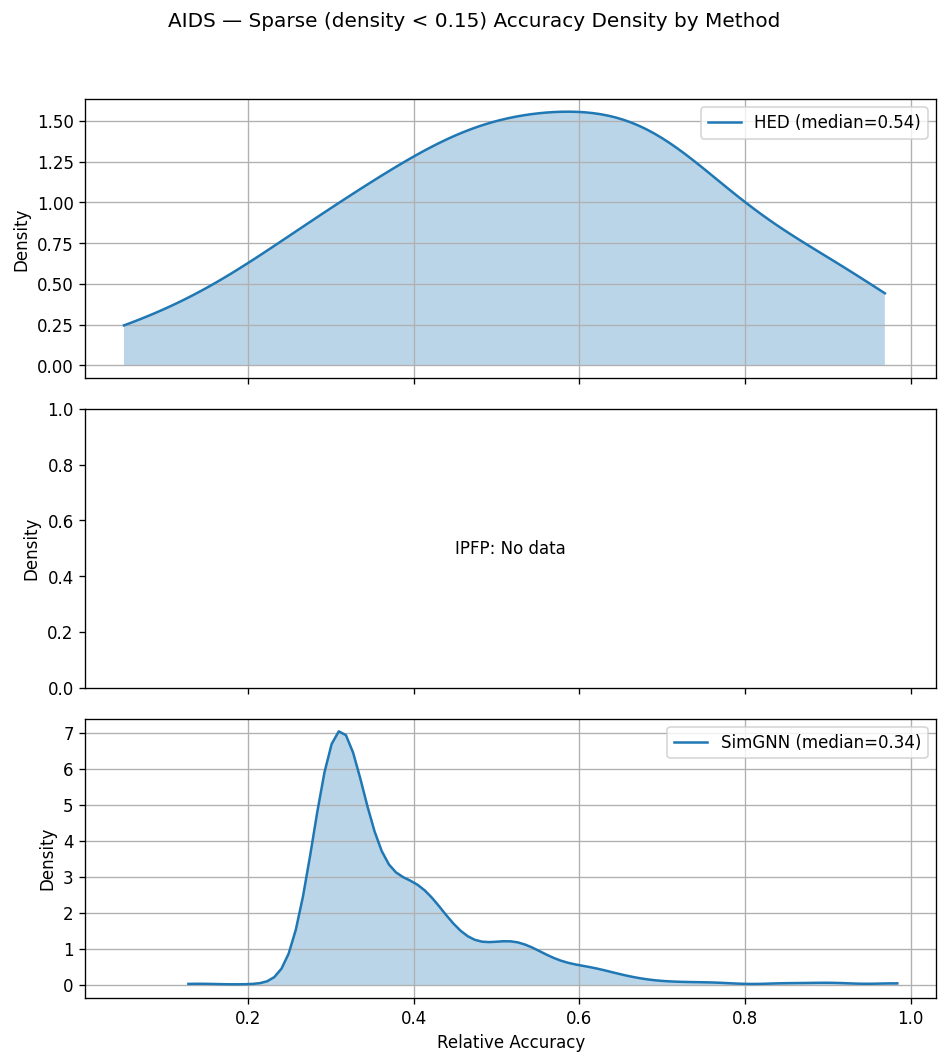

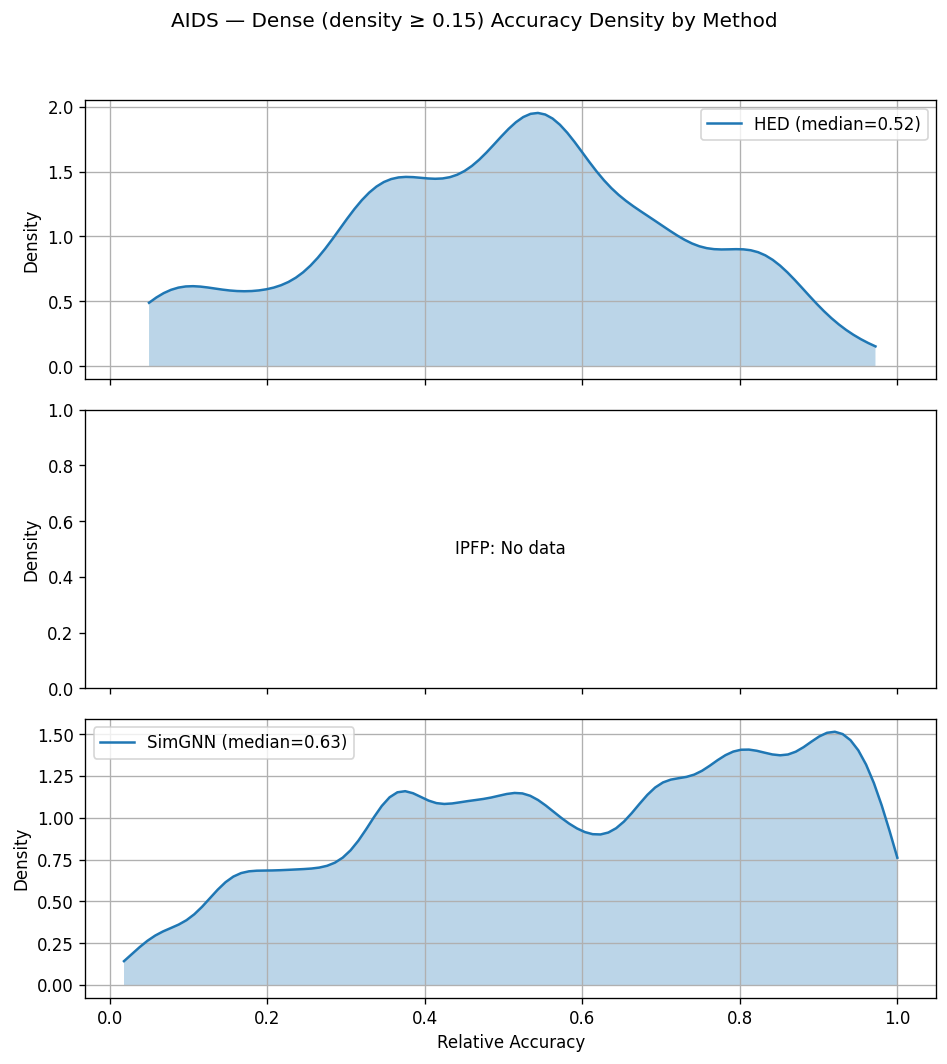

In [10]:
plot_accuracy_hist_by_density(dset="AIDS", density_threshold=0.15)

In [11]:
import os
import xml.etree.ElementTree as ET

def compute_graph_density(gxl_path):
    """
    Parses a GXL file and calculates its density.
    Density = 2 * E / (n * (n-1)) for an undirected graph.
    """
    try:
        tree = ET.parse(gxl_path)
        root = tree.getroot()
    except Exception as e:
        print(f"Error parsing {gxl_path}: {e}")
        return 0

    # Find the graph element
    graph_elem = root.find('graph')
    if graph_elem is None:
        print(f"No graph element found in {gxl_path}")
        return 0

    # Count nodes and edges
    nodes = graph_elem.findall('node')
    edges = graph_elem.findall('edge')
    n = len(nodes)
    e = len(edges)

    if n < 2:
        return 0
    density = 2 * e / (n * (n - 1))
    return density

def compute_pair_density(graph_id_1, graph_id_2, gxl_directory):
    """
    Given the ids of two graphs and the directory where the GXL files are stored,
    this function loads `graph_id_1.gxl` and `graph_id_2.gxl`, computes each individual
    density, and returns their mean.
    """
    path1 = os.path.join(gxl_directory, f"{graph_id_1}.gxl")
    path2 = os.path.join(gxl_directory, f"{graph_id_2}.gxl")

    density1 = compute_graph_density(path1)
    density2 = compute_graph_density(path2)

    mean_density = (density1 + density2) / 2.0
    return mean_density

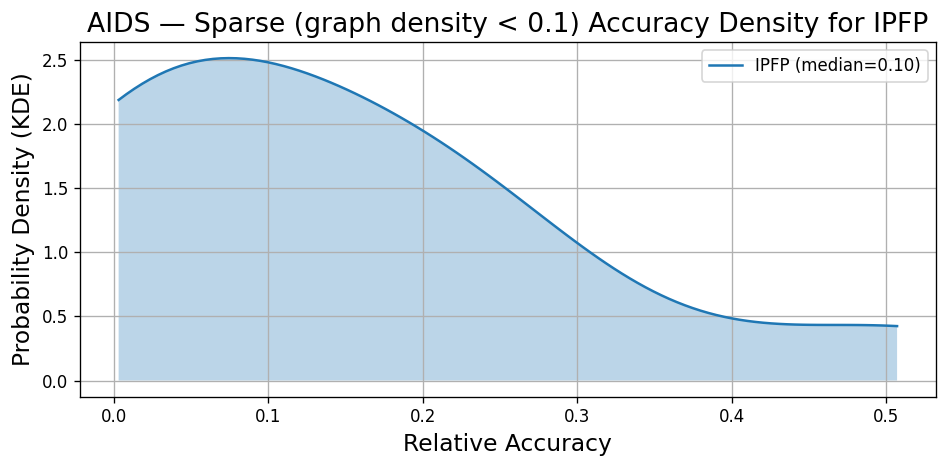

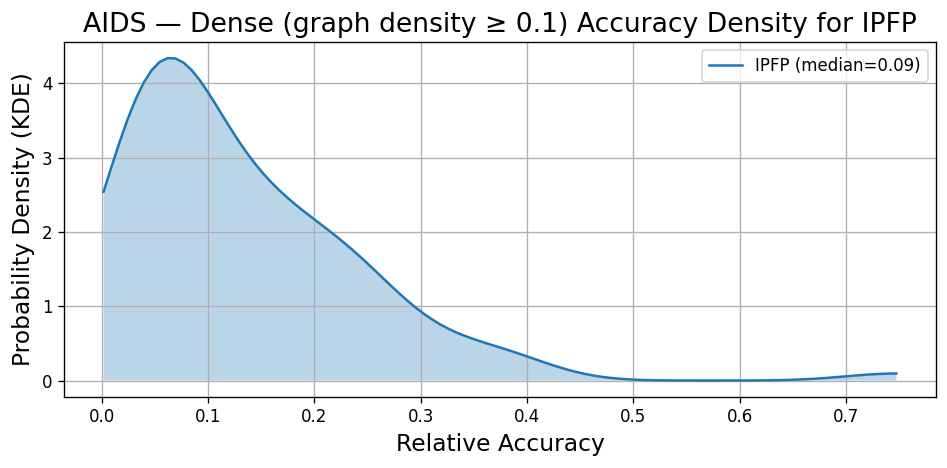

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

def plot_accuracy_hist_by_density_ipfp(dset, gxl_directory, density_threshold=0.1):
    """
    For the chosen dataset dset, create density plots for the IPFP method for two graph-density categories:
      1) Sparse (graph_density < density_threshold)
      2) Dense (graph_density >= density_threshold)

    This function computes the graph_density for IPFP using compute_pair_density,
    and then uses these densities for plotting the KDE of relative accuracy.
    """
    def get_df_with_pair_density(dset, gxl_directory):
        # Original data for IPFP
        df_ipfp = data[dset]["IPFP"].copy()
        # Compute pair density for each row and store the computed mean density.
        df_ipfp["graph_density"] = df_ipfp.apply(
            lambda row: compute_pair_density(row["graph_id_1"], row["graph_id_2"], gxl_directory),
            axis=1
        )
        return df_ipfp

    def plot_density(ax, series, label):
        if series.empty:
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center',
                    verticalalignment='center', transform=ax.transAxes)
            return

        if series.nunique() == 1 or series.std() == 0:
            const_val = series.iloc[0]
            x_range = np.linspace(const_val - 1e-3, const_val + 1e-3, 100)
            y = np.exp(-((x_range - const_val) ** 2) / (2 * 1e-6))
            y = y / y.max()
        else:
            x_min, x_max = series.min(), series.max()
            x_range = np.linspace(x_min, x_max, 100)
            try:
                kde = gaussian_kde(series)
                y = kde(x_range)
            except np.linalg.LinAlgError:
                series_noisy = series + np.random.normal(0, 1e-3, size=len(series))
                kde = gaussian_kde(series_noisy)
                y = kde(x_range)
        ax.plot(x_range, y, label=label)
        ax.fill_between(x_range, y, alpha=0.3)
        ax.legend()
        ax.grid(True)

    # Merge IPFP data with computed density and filter valid accuracy rows.
    df_merged = get_df_with_pair_density(dset, gxl_directory)
    df_valid = filter_valid_accuracy(df_merged)

    categories = [
        (f"Sparse (graph density < {density_threshold})", lambda df: df["graph_density"] < density_threshold),
        (f"Dense (graph density ≥ {density_threshold})", lambda df: df["graph_density"] >= density_threshold)
    ]

    for cat_title, cat_filter in categories:
        df_cat = df_valid[cat_filter(df_valid)]
        median_val = df_cat["accuracy"].median() if not df_cat.empty else np.nan

        fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
        if not df_cat.empty:
            label = f"IPFP (median={median_val:.2f})"
            plot_density(ax, df_cat["accuracy"], label)
        else:
            ax.text(0.5, 0.5, "IPFP: No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_ylabel("Probability Density (KDE)", fontsize=14)
        ax.set_xlabel("Relative Accuracy", fontsize=14)
        ax.set_title(f"{dset} — {cat_title} Accuracy Density for IPFP", fontsize=16)
        plt.tight_layout()
        plt.show()

# Example call; provide your actual GXL directory path.
plot_accuracy_hist_by_density_ipfp("AIDS", r"C:\project_data\processed_data\gxl\AIDS")

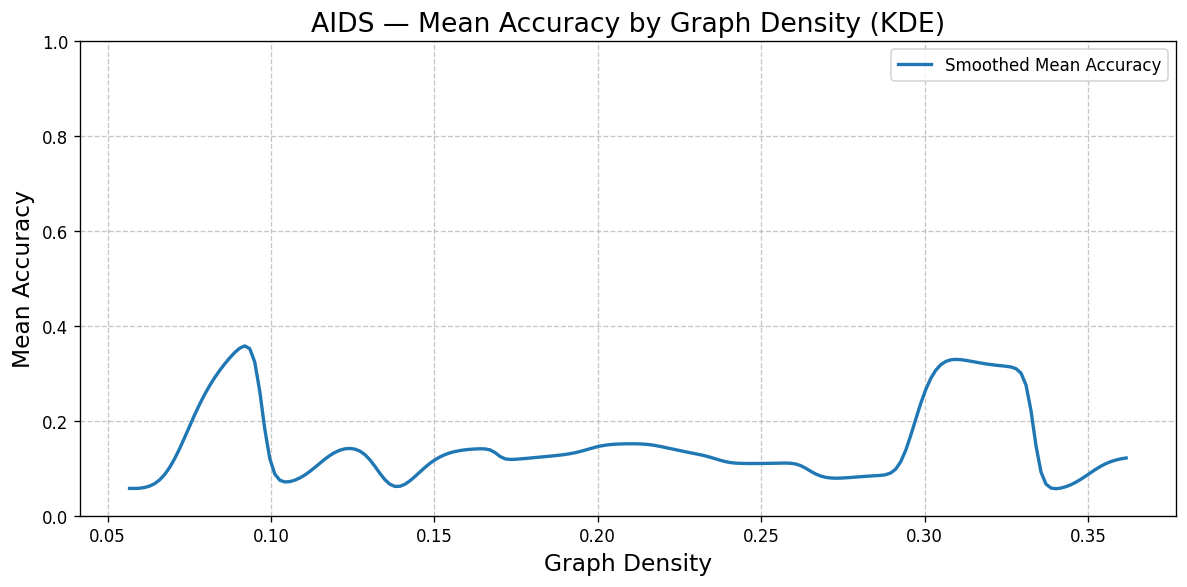

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_mean_accuracy_by_graph_density(dset, gxl_directory, bandwidth=None, num_points=200):
    """
    For the given dataset dset, compute the graph density for the IPFP method.
    Using a Gaussian kernel smoother, compute a smoothed mean accuracy over a grid of graph density values.
    """
    # Compute graph_density for each row in the IPFP data.
    df_ipfp = data[dset]["IPFP"].copy()
    df_ipfp["graph_density"] = df_ipfp.apply(
        lambda row: compute_pair_density(row["graph_id_1"], row["graph_id_2"], gxl_directory),
        axis=1
    )

    # Filter out rows with non-valid accuracy values.
    df_valid = filter_valid_accuracy(df_ipfp)
    if df_valid.empty:
        print("No valid data available for plotting.")
        return

    # x: graph_density, y: accuracy
    x = df_valid["graph_density"].values
    y = df_valid["accuracy"].values

    # Define grid for graph density
    x_min, x_max = x.min(), x.max()
    x_grid = np.linspace(x_min, x_max, num_points)

    # Use a default bandwidth if none provided
    if bandwidth is None:
        # Using a fraction of the standard deviation as bandwidth makes a reasonable choice.
        bandwidth = 0.1 * np.std(x)

    # Compute Gaussian kernel regression estimate at each x_grid point
    y_smooth = []
    for x0 in x_grid:
        # Compute Gaussian weights for all points
        weights = np.exp(-0.5 * ((x0 - x) / bandwidth)**2)
        # If the sum of weights is zero avoid division by zero
        if weights.sum() > 0:
            weighted_mean = np.average(y, weights=weights)
        else:
            weighted_mean = np.nan
        y_smooth.append(weighted_mean)
    y_smooth = np.array(y_smooth)

    # Plot the smoothed curve
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    ax.plot(x_grid, y_smooth, color='tab:blue', lw=2, label='Smoothed Mean Accuracy')
    ax.set_xlabel(r'Graph Density', fontsize=14)
    ax.set_ylabel(r'Mean Accuracy', fontsize=14)
    ax.set_ylim(0, 1)
    ax.set_title(f"{dset} \u2014 Mean Accuracy by Graph Density (KDE)", fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example call; provide your actual GXL directory path.
plot_mean_accuracy_by_graph_density("AIDS", r"C:\project_data\processed_data\gxl\AIDS")

In [14]:
import os
import xml.etree.ElementTree as ET

def compute_graph_size(gxl_path):
    """
    Parses a GXL file and calculates its size as a tuple.
    The size is defined by the number of unique nodes and edges.
    """
    try:
        tree = ET.parse(gxl_path)
        root = tree.getroot()
    except Exception as e:
        print(f"Error parsing {gxl_path}: {e}")
        return (0, 0)

    graph_elem = root.find('graph')
    if graph_elem is None:
        print(f"No graph element found in {gxl_path}")
        return (0, 0)

    # Using node 'id' attributes to ensure uniqueness
    node_ids = {node.get("id") for node in graph_elem.findall('node')}
    # For edges, simply count unique edge elements (could be modified if edges need further uniqueness criteria)
    edge_ids = set()
    for edge in graph_elem.findall('edge'):
        # Create a tuple of sorted 'from' and 'to' attributes for undirected uniqueness if available.
        src = edge.get("from")
        tgt = edge.get("to")
        if src is not None and tgt is not None:
            edge_ids.add(tuple(sorted((src, tgt))))
        else:
            edge_ids.add(edge)

    num_nodes = len(node_ids)
    num_edges = len(edge_ids)
    return num_nodes + num_edges

def compute_pair_size(graph_id_1, graph_id_2, gxl_directory):
    """
    Given the ids of two graphs and the directory where the GXL files are stored,
    this function loads `graph_id_1.gxl` and `graph_id_2.gxl`, computes each individual
    size (number of unique nodes and edges), and returns their mean as a tuple.
    """
    path1 = os.path.join(gxl_directory, f"{graph_id_1}.gxl")
    path2 = os.path.join(gxl_directory, f"{graph_id_2}.gxl")

    size1 = compute_graph_size(path1)
    size2 = compute_graph_size(path2)

    return (size1 + size2) / 2.0

C:\Users\mikef\AppData\Local\Temp\ipykernel_23324\863534646.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid.loc[:, "size_category"] = pd.cut(df_valid["graph_size"], bins=bins, labels=labels, include_lowest=True)


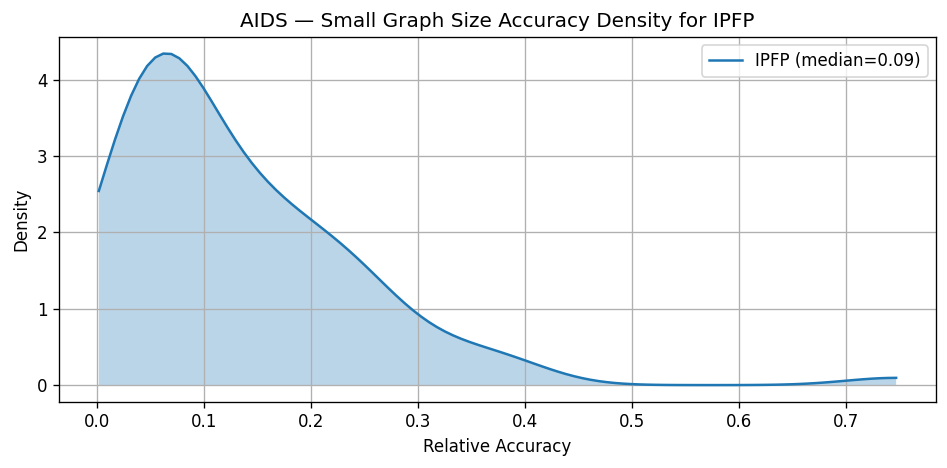

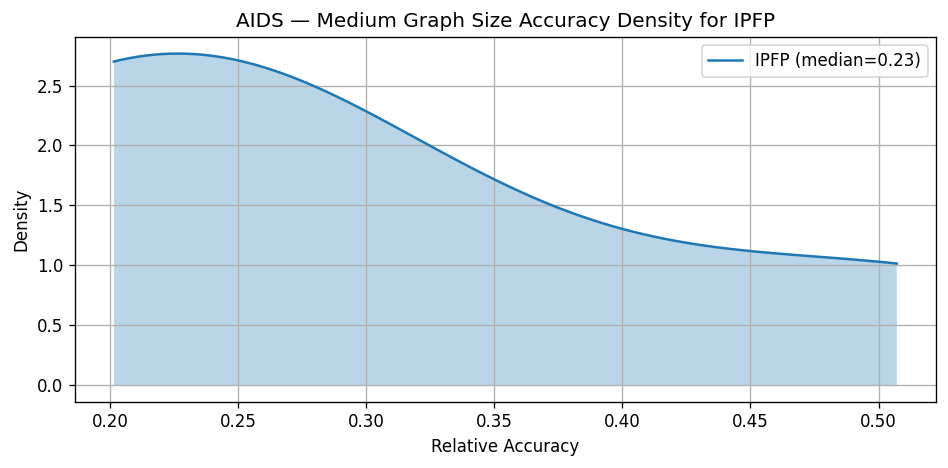

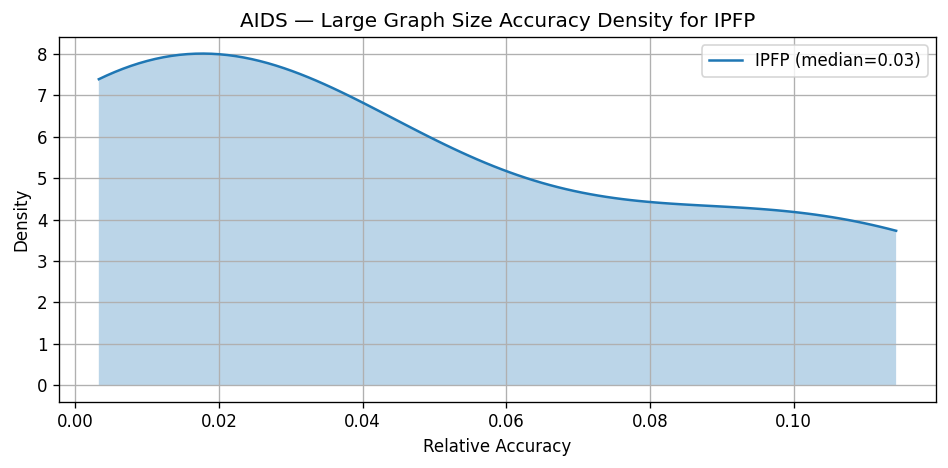

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd

def plot_accuracy_hist_by_size_ipfp(dset, gxl_directory):
    """
    For the chosen dataset dset, create density plots for the IPFP method for three graph size categories:
      1) Small
      2) Medium
      3) Large

    This function computes the graph_size for IPFP using compute_pair_size, bins the sizes into three equally
    spaced intervals (using the minimum and maximum size values), and then plots the KDE of relative accuracy.
    """
    def get_df_with_pair_size(dset, gxl_directory):
        # Original data for IPFP
        df_ipfp = data[dset]["IPFP"].copy()
        # Compute pair size for each row and store the computed size.
        df_ipfp["graph_size"] = df_ipfp.apply(
            lambda row: compute_pair_size(row["graph_id_1"], row["graph_id_2"], gxl_directory),
            axis=1
        )
        return df_ipfp

    def plot_density(ax, series, label):
        if series.empty:
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center',
                    verticalalignment='center', transform=ax.transAxes)
            return
        if series.nunique() == 1 or series.std() == 0:
            const_val = series.iloc[0]
            x_range = np.linspace(const_val - 1e-3, const_val + 1e-3, 100)
            y = np.exp(-((x_range - const_val) ** 2) / (2 * 1e-6))
            y = y / y.max()
        else:
            x_min, x_max = series.min(), series.max()
            x_range = np.linspace(x_min, x_max, 100)
            try:
                kde = gaussian_kde(series)
                y = kde(x_range)
            except np.linalg.LinAlgError:
                # Add slight noise if KDE computation fails.
                series_noisy = series + np.random.normal(0, 1e-3, size=len(series))
                kde = gaussian_kde(series_noisy)
                y = kde(x_range)
        ax.plot(x_range, y, label=label)
        ax.fill_between(x_range, y, alpha=0.3)
        ax.legend()
        ax.grid(True)

    # Merge IPFP data with computed size and filter valid accuracy rows.
    df_merged = get_df_with_pair_size(dset, gxl_directory)
    df_valid = filter_valid_accuracy(df_merged)

    # Compute minimum and maximum graph sizes to define bin edges.
    min_size = df_valid["graph_size"].min()
    max_size = df_valid["graph_size"].max()

    # Create bins for three equally spaced intervals: Small, Medium, and Large.
    bins = np.linspace(min_size, max_size, 4)
    labels = ["Small", "Medium", "Large"]

    # Categorize each row into a size category.
    df_valid.loc[:, "size_category"] = pd.cut(df_valid["graph_size"], bins=bins, labels=labels, include_lowest=True)

    # Plot the density for each graph size category.
    for cat in labels:
        df_cat = df_valid[df_valid["size_category"] == cat]
        median_val = df_cat["accuracy"].median() if not df_cat.empty else np.nan

        fig, ax = plt.subplots(figsize=(8, 4), dpi=120)
        if not df_cat.empty:
            label_str = f"IPFP (median={median_val:.2f})"
            plot_density(ax, df_cat["accuracy"], label_str)
        else:
            ax.text(0.5, 0.5, "IPFP: No data", ha="center", va="center", transform=ax.transAxes)
        ax.set_ylabel("Density")
        ax.set_xlabel("Relative Accuracy")
        ax.set_title(f"{dset} — {cat} Graph Size Accuracy Density for IPFP")
        plt.tight_layout()
        plt.show()
plot_accuracy_hist_by_size_ipfp("AIDS", r"C:\project_data\processed_data\gxl\AIDS")

In [16]:
import numpy as np
import pandas as pd

def calc_mean_graph_size_best_ipfp_accuracy(dset, gxl_directory):
    """
    For the given dataset dset, calculates the mean graph size for the cases where IPFP achieves its best accuracy.

    It first retrieves the IPFP data, computes the graph size for each row using compute_pair_size,
    filters valid accuracy entries using filter_valid_accuracy, and then calculates the mean graph size
    among all rows where the accuracy is equal to the best accuracy achieved.
    """
    # Retrieve IPFP data and compute graph sizes.
    df_ipfp = data[dset]["IPFP"].copy()
    df_ipfp["graph_size"] = df_ipfp.apply(
        lambda row: compute_pair_size(row["graph_id_1"], row["graph_id_2"], gxl_directory),
        axis=1
    )

    # Filter rows with valid accuracy values.
    df_valid = filter_valid_accuracy(df_ipfp)

    if df_valid.empty:
        return None

    # Determine the best accuracy value (assuming higher accuracy is better).
    best_accuracy = df_valid["accuracy"].max()

    # Filter rows where the accuracy equals the best value.
    best_df = df_valid[df_valid["accuracy"] == best_accuracy]

    # Compute and return the mean graph size for those cases.
    mean_graph_size = best_df["graph_size"].mean()
    return mean_graph_size

result = calc_mean_graph_size_best_ipfp_accuracy("AIDS", r"C:\project_data\processed_data\gxl\AIDS")
print("Mean graph size for best IPFP accuracy:", result)

Mean graph size for best IPFP accuracy: 86.5


In [17]:
def get_df_with_diversities(dset, method, df_diversities):
    """
    Merge method's accuracy data with node/edge diversity values.
    Ensures correct graph ID matching and non-negative accuracy.
    """
    df_method = data[dset][method].copy()

    # Merge with node & edge diversity values
    df_merged = pd.merge(
        df_method, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )

    # Ensure accuracy is valid (non-negative)
    df_merged = df_merged[df_merged["accuracy"] >= 0]

    return df_merged

def plot_density(ax, data_series, method_label):
    """
    Helper to plot a kernel density estimate (KDE) with fill.
    """
    if data_series.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        return

    x_min, x_max = data_series.min(), data_series.max()
    if x_min == x_max:
        ax.axvline(x_min, color='black', linestyle='--', label=method_label)
        ax.text(x_min, 0.5, f"All = {x_min:.2f}", rotation=90, ha='center', va='center', transform=ax.get_yaxis_transform())
        ax.legend()
        ax.grid(True)
        return

    x_range = np.linspace(x_min, x_max, 100)
    kde = gaussian_kde(data_series)
    y = kde(x_range)

    ax.plot(x_range, y, label=method_label)
    ax.fill_between(x_range, y, alpha=0.3)
    ax.legend()
    ax.grid(True)


In [18]:
# Choose a dataset to plot
dataset_name = "AIDS"

# Load the node/edge label diversities
table_dir = r"C:\project_data\results\label_diversity"
file_1 = os.path.join(table_dir, f"{dataset_name}_node_edge_label_diversities_part1.xlsx")
file_2 = os.path.join(table_dir, f"{dataset_name}_node_edge_label_diversities_part2.xlsx")

# Read the two partial Excel files, forcing graph_id columns to string
df_part1 = pd.read_excel(file_1, dtype={"graph_id_1": str, "graph_id_2": str})
df_part2 = pd.read_excel(file_2, dtype={"graph_id_1": str, "graph_id_2": str})

# Concatenate them into a single DataFrame
df_diversities_merged = pd.concat([df_part1, df_part2], ignore_index=True)

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_df_with_diversities(dset, method, df_diversities):
    df_method = data[dset][method].copy()
    df_merged = pd.merge(
        df_method, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    df_merged = df_merged[df_merged["accuracy"] >= 0]
    return df_merged

def plot_accuracy_vs_node_diversity(dset, df_diversities):
    # --- Step 1: Collect IPFP data and filter ---
    ipfp_method = "IPFP"
    df_ipfp = get_df_with_diversities(dset, ipfp_method, df_diversities)
    df_ipfp_valid = df_ipfp.dropna(subset=["node_labels", "ged"])
    df_ipfp_valid = df_ipfp_valid[df_ipfp_valid["ged"] > 0]
    if df_ipfp_valid.empty:
        print(f"Skipping {ipfp_method} - No valid data available.")
        return

    # Group by node_labels and compute mean GED for IPFP
    df_ipfp_grouped = df_ipfp_valid.groupby("node_labels", as_index=False)["ged"].mean()

    # --- Step 2: Collect Exact data and filter ---
    df_exact = data[dset]["Exact"].copy()
    df_exact_merged = pd.merge(
        df_exact, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    df_exact_valid = df_exact_merged.dropna(subset=["node_labels", "ged_exact"])
    df_exact_valid = df_exact_valid[df_exact_valid["ged_exact"] > 0]

    if df_exact_valid.empty:
        print("Skipping Exact - No valid data available.")
        df_exact_grouped = pd.DataFrame(columns=["node_labels", "ged_exact"])
    else:
        # Group by node_labels and compute mean GED for Exact
        df_exact_grouped = df_exact_valid.groupby("node_labels", as_index=False)["ged_exact"].mean()

    # --- Step 3: Keep only node_labels common to both IPFP and Exact ---
    common_labels = set(df_ipfp_grouped["node_labels"]).intersection(df_exact_grouped["node_labels"])
    df_ipfp_common = df_ipfp_grouped[df_ipfp_grouped["node_labels"].isin(common_labels)]
    df_exact_common = df_exact_grouped[df_exact_grouped["node_labels"].isin(common_labels)]
    merged_groups = pd.merge(df_ipfp_common, df_exact_common, on="node_labels", how="inner")

    # Sort by node_labels to get a nice top-to-bottom order
    merged_groups.sort_values("node_labels", ascending=True, inplace=True)

    # --- Step 4: Create the slope chart ---
    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

    # Remove top and right spines for a cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Plot IPFP points (orange)
    ax.scatter(
        merged_groups["ged"],
        merged_groups["node_labels"],
        s=60,            # smaller markers
        color="orange",
        label="IPFP",
        alpha=0.9,
        zorder=3
    )

    # Plot Exact points (blue)
    ax.scatter(
        merged_groups["ged_exact"],
        merged_groups["node_labels"],
        s=60,            # smaller markers
        color="blue",
        label="Exact",
        alpha=0.9,
        zorder=3
    )

    # Connect each pair with a black line and print the absolute error above it
    for _, row in merged_groups.iterrows():
        # Draw connecting line
        ax.plot(
            [row["ged"], row["ged_exact"]],
            [row["node_labels"], row["node_labels"]],
            color="black",
            lw=1.5,
            alpha=0.8,
            zorder=2
        )
        # Compute absolute error
        abs_err = abs(row["ged_exact"] - row["ged"])
        # Compute the x-position as the mid-point of the two values
        x_text = (row["ged"] + row["ged_exact"]) / 2
        # Set y-position slightly above the node label value
        y_text = row["node_labels"] + 0.05
        ax.text(x_text, y_text, f"{abs_err:.1f}", fontsize=10, ha="center", va="bottom", color="black")

    # Light gray grid for a clean look
    ax.grid(True, color="lightgrey", linestyle="-", linewidth=0.7)

    # Labels and Title
    ax.set_title(f"{dset} — IPFP vs. Exact GED by Node Diversity", fontsize=14, pad=15)
    ax.set_xlabel("GED Value", fontsize=12)
    ax.set_ylabel("Node Label Diversity", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Move legend to lower right
    ax.legend(loc="lower right", frameon=False, fontsize=10)

    plt.tight_layout()
    plt.show()


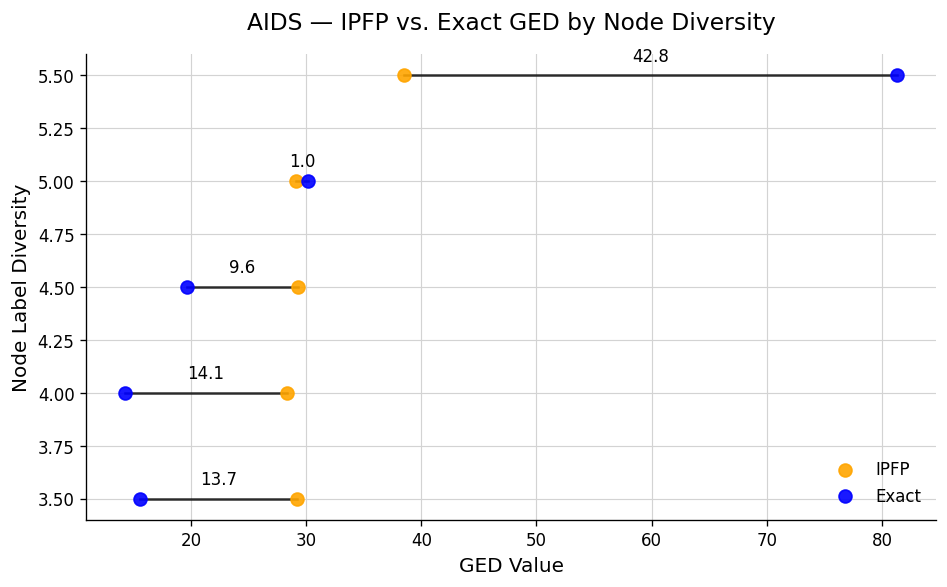

In [20]:
plot_accuracy_vs_node_diversity(dataset_name, df_diversities_merged)


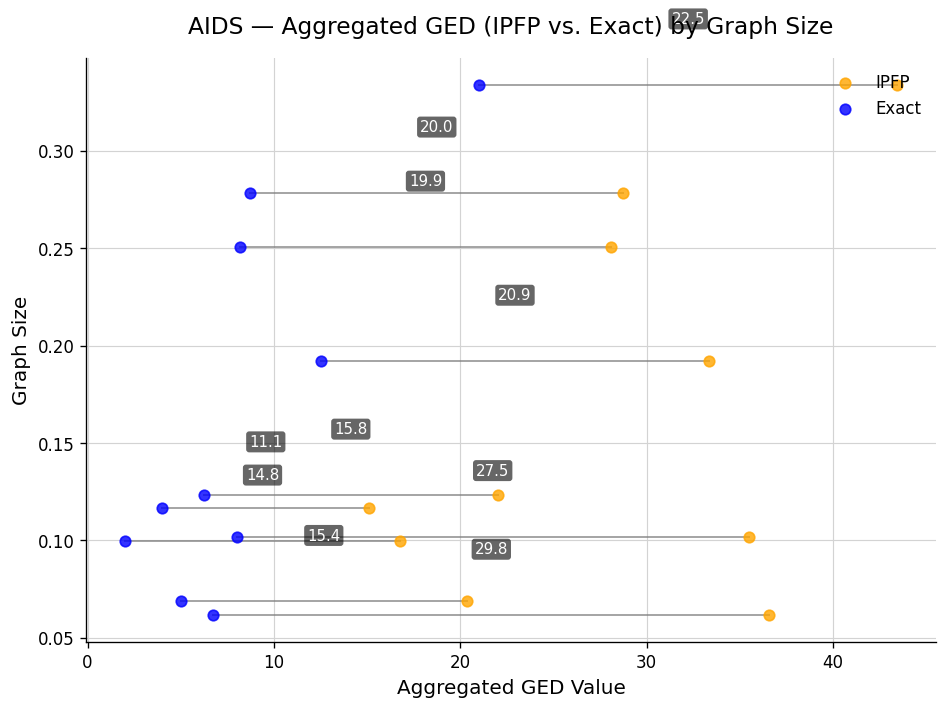

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_ged_vs_graph_size_continuous(dset, gxl_directory):
    """
    For the chosen dataset `dset`, compute graph sizes (or densities) for both IPFP and Exact
    methods, merge and aggregate them by the unique graph_size, then plot an aggregated slope
    chart (one point for IPFP, one for Exact) connected by a line, labeled with the absolute
    error only if it's above a chosen threshold.
    """

    # --- Step 1: Process IPFP data ---
    df_ipfp = data[dset]["IPFP"].copy()
    # Rename GED column if needed; for instance, if it's "ged_ipfp" in your dataset:
    # df_ipfp.rename(columns={"ged_ipfp": "ged"}, inplace=True)

    df_ipfp["graph_size_ipfp"] = df_ipfp.apply(
        lambda row: compute_pair_density(row["graph_id_1"], row["graph_id_2"], gxl_directory),
        axis=1
    )
    df_ipfp = df_ipfp[df_ipfp["ged"].notna() & (df_ipfp["ged"] > 0)]

    # --- Step 2: Process Exact data ---
    df_exact = data[dset]["Exact"].copy()

    # If your Exact data uses "ged" instead of "ged_exact", rename it:
    if "ged_exact" not in df_exact.columns:
        if "ged" in df_exact.columns:
            df_exact.rename(columns={"ged": "ged_exact"}, inplace=True)
        else:
            print("Error: Neither 'ged_exact' nor 'ged' found in Exact dataset.")
            return

    df_exact["graph_size_exact"] = df_exact.apply(
        lambda row: compute_pair_density(row["graph_id_1"], row["graph_id_2"], gxl_directory),
        axis=1
    )
    df_exact = df_exact[df_exact["ged_exact"].notna() & (df_exact["ged_exact"] > 0)]

    # --- Step 3: Merge on graph pair IDs ---
    merged_df = pd.merge(
        df_ipfp, df_exact,
        on=["graph_id_1", "graph_id_2"],
        suffixes=("_ipfp", "_exact"),
        how="inner"
    )
    if merged_df.empty:
        print("No common graph pairs found with valid GED values.")
        return

    # Use IPFP's computed size/density as representative
    merged_df["graph_size"] = merged_df["graph_size_ipfp"]

    # --- Step 4: Aggregate by graph_size ---
    # We want one row per unique graph_size, so we take the mean of the IPFP and Exact GEDs.
    # Notice the merged columns might be "ged" (from IPFP) and "ged_exact" (from Exact).
    df_agg = (
        merged_df
        .groupby("graph_size", as_index=False)
        .agg({
            "ged": "mean",
            "ged_exact_exact": "mean"
        })
        .rename(columns={"ged": "ged_ipfp_mean", "ged_exact_exact": "ged_exact_mean"})
    )

    # Sort by graph_size ascending (smallest at bottom, largest at top).
    # If you prefer largest at the top, use ascending=False and then invert the y-axis.
    df_agg.sort_values("graph_size", ascending=True, inplace=True)

    # --- Select 10 random rows ---
    df_sample = df_agg.sample(n=10, random_state=42)

    # --- Step 5: Create slope chart ---
    fig, ax = plt.subplots(figsize=(8, 6), dpi=120)

    # Clean up spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Plot IPFP aggregated points (orange)
    ax.scatter(
        df_sample["ged_ipfp_mean"], df_sample["graph_size"],
        s=40, color="orange", alpha=0.8, label="IPFP", zorder=3
    )

    # Plot Exact aggregated points (blue)
    ax.scatter(
        df_sample["ged_exact_mean"], df_sample["graph_size"],
        s=40, color="blue", alpha=0.8, label="Exact", zorder=3
    )

    # Connect each aggregated pair with a horizontal line and label the absolute error if above a threshold.
    error_threshold = 1.0  # Only label if |Exact - IPFP| > 1.0
    for _, row in df_sample.iterrows():
        x_ipfp = row["ged_ipfp_mean"]
        x_exact = row["ged_exact_mean"]
        y_val = row["graph_size"]

        ax.plot(
            [x_ipfp, x_exact], [y_val, y_val],
            color="gray", lw=1.2, alpha=0.7, zorder=2
        )

        abs_err = abs(x_exact - x_ipfp)
        if abs_err > error_threshold:
            x_text = (x_ipfp + x_exact) / 2
            y_text = y_val + 0.03  # Slight offset above the line
            ax.text(
                x_text, y_text, f"{abs_err:.1f}",
                fontsize=9, ha="center", va="bottom", color="white",
                bbox=dict(boxstyle="round,pad=0.2", fc="black", ec="none", alpha=0.6)
            )

    ax.set_xlabel("Aggregated GED Value", fontsize=12)
    ax.set_ylabel("Graph Size", fontsize=12)
    ax.set_title(f"{dset} — Aggregated GED (IPFP vs. Exact) by Graph Size", fontsize=14, pad=15)
    ax.legend(loc="upper right", frameon=False, fontsize=10)

    ax.grid(True, color="lightgrey", linestyle="-", linewidth=0.7)

    plt.tight_layout()
    plt.show()

plot_ged_vs_graph_size_continuous("AIDS", r"C:\project_data\processed_data\gxl\AIDS")

In [22]:


def plot_accuracy_vs_size(dset, df_diversities):
    # --- Step 1: Collect IPFP data and filter ---
    ipfp_method = "IPFP"
    df_ipfp = get_df_with_diversities(dset, ipfp_method, df_diversities)
    df_ipfp_valid = df_ipfp.dropna(subset=["node_labels", "ged"])
    df_ipfp_valid = df_ipfp_valid[df_ipfp_valid["ged"] > 0]
    if df_ipfp_valid.empty:
        print(f"Skipping {ipfp_method} - No valid data available.")
        return

    # Group by node_labels and compute mean GED for IPFP
    df_ipfp_grouped = df_ipfp_valid.groupby("node_labels", as_index=False)["ged"].mean()

    # --- Step 2: Collect Exact data and filter ---
    df_exact = data[dset]["Exact"].copy()
    df_exact_merged = pd.merge(
        df_exact, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    df_exact_valid = df_exact_merged.dropna(subset=["node_labels", "ged_exact"])
    df_exact_valid = df_exact_valid[df_exact_valid["ged_exact"] > 0]

    if df_exact_valid.empty:
        print("Skipping Exact - No valid data available.")
        df_exact_grouped = pd.DataFrame(columns=["node_labels", "ged_exact"])
    else:
        # Group by node_labels and compute mean GED for Exact
        df_exact_grouped = df_exact_valid.groupby("node_labels", as_index=False)["ged_exact"].mean()

    # --- Step 3: Keep only node_labels common to both IPFP and Exact ---
    common_labels = set(df_ipfp_grouped["node_labels"]).intersection(df_exact_grouped["node_labels"])
    df_ipfp_common = df_ipfp_grouped[df_ipfp_grouped["node_labels"].isin(common_labels)]
    df_exact_common = df_exact_grouped[df_exact_grouped["node_labels"].isin(common_labels)]
    merged_groups = pd.merge(df_ipfp_common, df_exact_common, on="node_labels", how="inner")

    # Sort by node_labels to get a nice top-to-bottom order
    merged_groups.sort_values("node_labels", ascending=True, inplace=True)

    # --- Step 4: Create the slope chart ---
    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

    # Remove top and right spines for a cleaner look
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Plot IPFP points (orange)
    ax.scatter(
        merged_groups["ged"],
        merged_groups["node_labels"],
        s=60,            # smaller markers
        color="orange",
        label="IPFP",
        alpha=0.9,
        zorder=3
    )

    # Plot Exact points (blue)
    ax.scatter(
        merged_groups["ged_exact"],
        merged_groups["node_labels"],
        s=60,            # smaller markers
        color="blue",
        label="Exact",
        alpha=0.9,
        zorder=3
    )

    # Connect each pair with a black line and print the absolute error above it
    for _, row in merged_groups.iterrows():
        # Draw connecting line
        ax.plot(
            [row["ged"], row["ged_exact"]],
            [row["node_labels"], row["node_labels"]],
            color="black",
            lw=1.5,
            alpha=0.8,
            zorder=2
        )
        # Compute absolute error
        abs_err = abs(row["ged_exact"] - row["ged"])
        # Compute the x-position as the mid-point of the two values
        x_text = (row["ged"] + row["ged_exact"]) / 2
        # Set y-position slightly above the node label value
        y_text = row["node_labels"] + 0.05
        ax.text(x_text, y_text, f"{abs_err:.1f}", fontsize=10, ha="center", va="bottom", color="black")

    # Light gray grid for a clean look
    ax.grid(True, color="lightgrey", linestyle="-", linewidth=0.7)

    # Labels and Title
    ax.set_title(f"{dset} — IPFP vs. Exact GED by Node Diversity", fontsize=14, pad=15)
    ax.set_xlabel("GED Value", fontsize=12)
    ax.set_ylabel("Node Label Diversity", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Move legend to lower right
    ax.legend(loc="lower right", frameon=False, fontsize=10)

    plt.tight_layout()
    plt.show()


In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_df_with_diversities(dset, method, df_diversities):
    df_method = data[dset][method].copy()
    df_merged = pd.merge(
        df_method, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    df_merged = df_merged[df_merged["accuracy"] >= 0]
    return df_merged

def plot_accuracy_vs_edge_diversity(dset, df_diversities):
    # --- Step 1: Process IPFP Data ---
    ipfp_method = "IPFP"
    df_ipfp = get_df_with_diversities(dset, ipfp_method, df_diversities)
    df_ipfp_valid = df_ipfp.dropna(subset=["edge_labels", "ged"])
    df_ipfp_valid = df_ipfp_valid[df_ipfp_valid["ged"] > 0]
    if df_ipfp_valid.empty:
        print(f"Skipping {ipfp_method} - No valid data available.")
        return

    # Group by edge_labels and compute mean GED for IPFP.
    df_ipfp_grouped = df_ipfp_valid.groupby("edge_labels", as_index=False)["ged"].mean()

    # --- Step 2: Process Exact Data ---
    df_exact = data[dset]["Exact"].copy()
    df_exact_merged = pd.merge(
        df_exact, df_diversities,
        on=["graph_id_1", "graph_id_2"],
        how="left",
        suffixes=("", "_div")
    )
    df_exact_valid = df_exact_merged.dropna(subset=["edge_labels", "ged_exact"])
    df_exact_valid = df_exact_valid[df_exact_valid["ged_exact"] > 0]
    if df_exact_valid.empty:
        print("Skipping Exact - No valid data available.")
        df_exact_grouped = pd.DataFrame(columns=["edge_labels", "ged_exact"])
    else:
        # Group by edge_labels and compute mean GED for Exact.
        df_exact_grouped = df_exact_valid.groupby("edge_labels", as_index=False)["ged_exact"].mean()

    # --- Step 3: Keep Only Common Edge Diversity Values ---
    common_labels = set(df_ipfp_grouped["edge_labels"]).intersection(df_exact_grouped["edge_labels"])
    df_ipfp_common = df_ipfp_grouped[df_ipfp_grouped["edge_labels"].isin(common_labels)]
    df_exact_common = df_exact_grouped[df_exact_grouped["edge_labels"].isin(common_labels)]

    # Merge for connecting lines.
    merged_groups = pd.merge(df_ipfp_common, df_exact_common, on="edge_labels", how="inner")
    merged_groups.sort_values("edge_labels", ascending=True, inplace=True)

    # --- Step 4: Create the Slope Chart for Edge Diversity ---
    fig, ax = plt.subplots(figsize=(8, 5), dpi=120)

    # Remove top and right spines.
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Plot IPFP points (orange).
    ax.scatter(
        df_ipfp_common["ged"],
        df_ipfp_common["edge_labels"],
        s=60, color="orange", label="IPFP", alpha=0.9, zorder=3
    )

    # Plot Exact points (blue).
    ax.scatter(
        df_exact_common["ged_exact"],
        df_exact_common["edge_labels"],
        s=60, color="blue", label="Exact", alpha=0.9, zorder=3
    )

    # Connect each pair with a black line.
    for _, row in merged_groups.iterrows():
        ax.plot(
            [row["ged"], row["ged_exact"]],
            [row["edge_labels"], row["edge_labels"]],
            color="black", lw=1.5, alpha=0.8, zorder=2
        )

    # Grid, labels, and title.
    ax.grid(True, color="lightgrey", linestyle="-", linewidth=0.7)
    ax.set_title(f"{dset} — IPFP vs. Exact GED by Edge Diversity", fontsize=14, pad=15)
    ax.set_xlabel("GED Value", fontsize=12)
    ax.set_ylabel("Edge Label Diversity", fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)

    # Place the legend in the lower right.
    ax.legend(loc="lower right", frameon=False, fontsize=10)

    plt.tight_layout()
    plt.show()


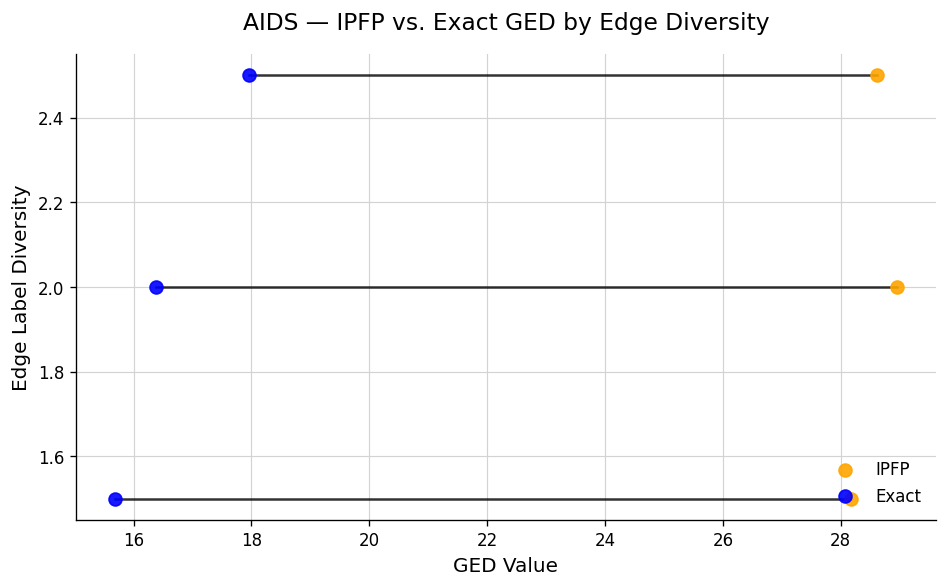

In [24]:
plot_accuracy_vs_edge_diversity(dataset_name, df_diversities_merged)

## 7. Scatter plot for Accuracy Analysis

In [25]:
import matplotlib as mpl

def plot_accuracy_scatter(dset, method):
    """
    For the chosen dataset `dset` and given `method`, create a 2D hexbin plot
    comparing the approximate GED results (ged) against the exact GED results (ged_exact).

    Each hexagon is colored by the count of observations in that bin,
    using a custom lavender colormap from very light (#E6E6FA) to bright (#8A2BE2).
    The diagonal (y = x) represents the exact GED.
    The figure is sized to an HD-like resolution (1280x720).
    """

    # Define a custom lavender colormap from light to bright
    lavender_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        "LavenderMap",
        ["#E6E6FA", "#B299FF", "#8A2BE2"]  # Light → Medium → Bright lavender
    )

    # Set HD-like resolution: 12.8" x 7.2" at 100 DPI ~ 1280 x 720 pixels
    plt.figure(figsize=(12.8, 7.2), dpi=100)

    # Collect all (x, y) points for the chosen method
    all_exact = []
    all_approx = []
    df_method = data[dset][method].dropna(subset=['ged', 'ged_exact'])
    all_exact.extend(df_method["ged_exact"].tolist())
    all_approx.extend(df_method["ged"].tolist())

    # Plot hexbin only if we have points
    if all_exact and all_approx:
        hb = plt.hexbin(
            all_exact,
            all_approx,
            gridsize=100,          # number of hexagons along each axis
            cmap=lavender_cmap,   # our custom lavender colormap
            mincnt=1              # only color bins that have at least one point
        )
        cb = plt.colorbar(hb)
        cb.set_label("Count")

        # Draw the diagonal
        lower = min(min(all_exact), min(all_approx))
        upper = max(max(all_exact), max(all_approx))
        plt.plot([lower, upper], [lower, upper], 'k--', label="Exact GED (y = x)")

    # Clamp axes to [0, 250]
    limit = 40
    plt.xlim(0, limit)
    plt.ylim(0, limit)

    plt.title(f"{dset} — Approximate GED vs Exact GED (Hexbin: {method})")
    plt.xlabel("Exact GED")
    plt.ylabel("Approximate GED")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

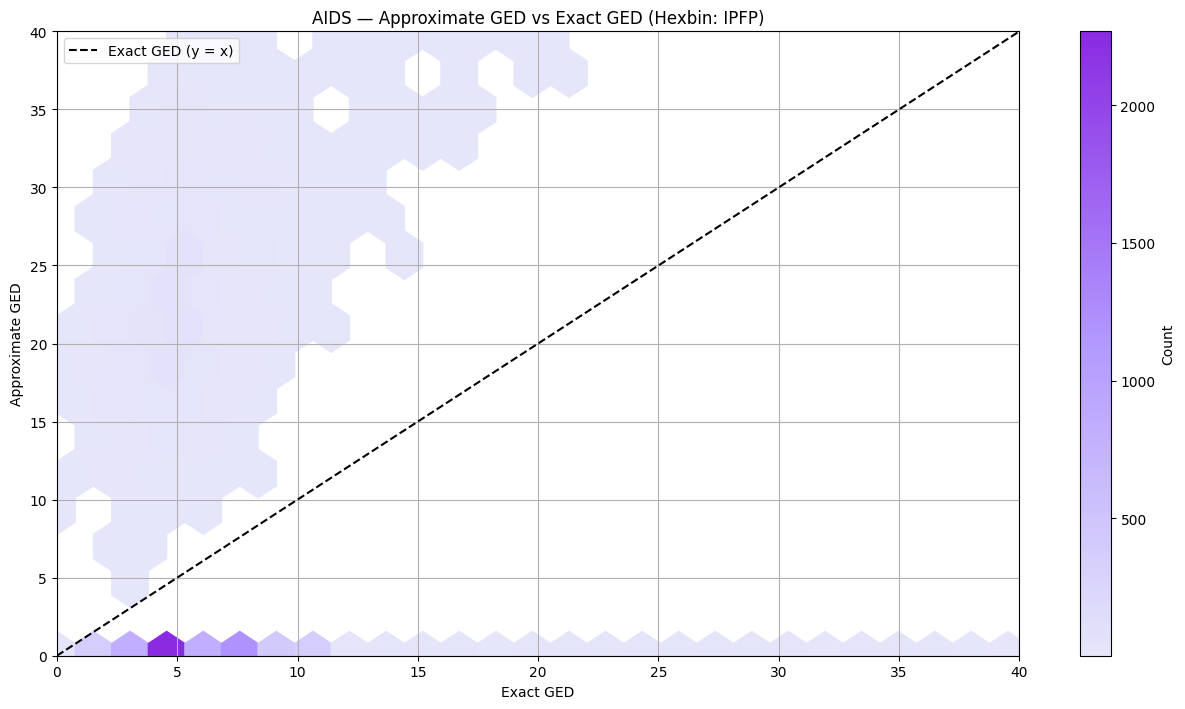

In [26]:
plot_accuracy_scatter("AIDS", "IPFP")

In [27]:
!{sys.executable} -m pip install statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [28]:
def plot_runtime_by_size(dset):
    """
    Plots the runtime (in ms) vs. graph size for each method (HED, IPFP, SimGNN),
    with a black line showing the grouped average runtime, and a LOESS smooth
    curve (colored lavender).
    """
    methods = ["HED", "IPFP", "SimGNN"]

    fig, axes = plt.subplots(nrows=len(methods), figsize=(12.8, 7.2), sharex=True, dpi=120)

    # If there's only one method, axes is not a list
    if len(methods) == 1:
        axes = [axes]

    for i, method in enumerate(methods):
        df_method = data[dset][method]
        # Drop rows with missing runtime
        df_method = df_method.dropna(subset=["runtime"])
        # Remove rows where runtime is zero or near zero (threshold can be adjusted)
        df_method = df_method[(df_method["runtime"] > 0) & (df_method["runtime"] < 6)]

        # Merge to get graph_size from SimGNN if needed
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_size"]]
        df_method = pd.merge(
            df_method,
            df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )
        df_method["graph_size"] = df_method["graph_size_simgnn"]
        df_method = df_method.dropna(subset=["graph_size", "runtime"])

        if df_method.empty:
            axes[i].text(0.5, 0.5, f"No data for {method}",
                         ha='center', va='center', transform=axes[i].transAxes)
            continue

        # Convert runtime to milliseconds
        df_method["runtime_ms"] = df_method["runtime"] * 1000

        # Convert graph_size to integer for grouping
        df_method["graph_size_int"] = df_method["graph_size"].astype(int)

        # Group by integer graph size
        grouped = (
            df_method.groupby("graph_size_int")["runtime_ms"]
            .mean()
            .reset_index()
            .sort_values("graph_size_int")
        )

        # Plot average runtime as a black line (or scatter if only 1 point)
        if grouped["graph_size_int"].nunique() > 1:
            axes[i].plot(grouped["graph_size_int"], grouped["runtime_ms"], color="black")
        else:
            axes[i].scatter(grouped["graph_size_int"], grouped["runtime_ms"], color="black")

        # --- Add LOESS smooth curve in lavender ---
        # Only do LOESS if we have multiple x-values
        if grouped["graph_size_int"].nunique() > 1:
            x_vals = grouped["graph_size_int"].values
            y_vals = grouped["runtime_ms"].values

            # frac=0.3 controls the smoothness; adjust as needed
            loess_smoothed = lowess(endog=y_vals, exog=x_vals, frac=0.3)
            # loess_smoothed is Nx2 array: first column x, second column smoothed y
            axes[i].plot(
                loess_smoothed[:, 0],
                loess_smoothed[:, 1],
                color="red",
                linewidth=2,
                label="LOESS Smooth"
            )

        axes[i].set_title(f"{method}")
        axes[i].set_ylabel("Runtime (ms)")
        axes[i].grid(True)

        # Set x-limits based on min and max integer graph size
        min_size = grouped["graph_size_int"].min()
        max_size = grouped["graph_size_int"].max()
        axes[i].set_xlim(min_size - 1, max_size + 1)

        # Optionally add a legend
        axes[i].legend(loc="best")

    # Shared X-axis label
    axes[-1].set_xlabel("Graph Size")
    fig.suptitle(f"{dset} — Runtime by Graph Size")
    plt.tight_layout()
    plt.show()


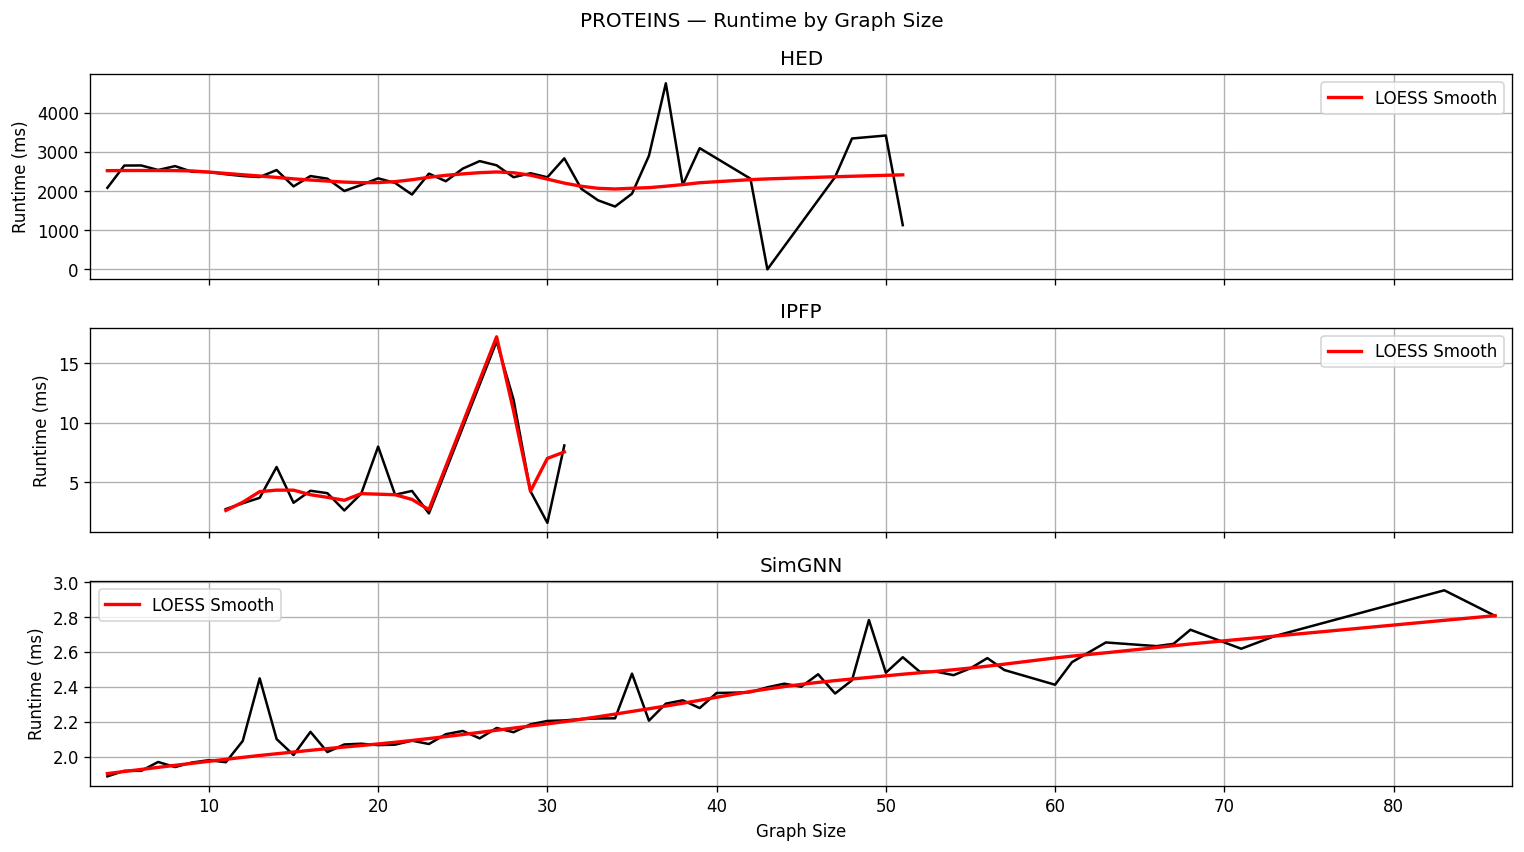

In [29]:
plot_runtime_by_size("PROTEINS")


In [30]:
def plot_runtime_by_density(dset):
    """
    Plots the runtime (in ms) vs. graph density (0–1) for each method (HED, IPFP, SimGNN).
    A black line shows the binned average runtime, and a LOESS smooth curve in lavender
    is superimposed to show the smoothed trend.

    The figure is sized to HD-like resolution (1280x720).
    """
    methods = ["HED", "IPFP", "SimGNN"]

    fig, axes = plt.subplots(nrows=len(methods), figsize=(12.8, 7.2), sharex=True, dpi=100)

    # If there's only one method in the list, axes won't be a list
    if len(methods) == 1:
        axes = [axes]

    for i, method in enumerate(methods):
        df_method = data[dset][method]

        # Drop rows with missing runtime
        df_method = df_method.dropna(subset=["runtime"])

        # Merge to get graph_density from SimGNN if needed
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_density"]]
        df_method = pd.merge(
            df_method,
            df_simgnn,
            on=["graph_id_1", "graph_id_2"],
            how="left",
            suffixes=("", "_simgnn")
        )

        df_method["graph_density"] = df_method["graph_density_simgnn"]
        df_method = df_method.dropna(subset=["graph_density", "runtime"])
        if df_method.empty:
            axes[i].text(0.5, 0.5, f"No data for {method}", ha='center', va='center',
                         transform=axes[i].transAxes)
            continue

        # Convert runtime to milliseconds
        df_method["runtime_ms"] = df_method["runtime"] * 1000

        # Filter out runtime outliers using the IQR method
        q1 = df_method["runtime_ms"].quantile(0.25)
        q3 = df_method["runtime_ms"].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        df_method = df_method[df_method["runtime_ms"] <= upper_bound]

        # Bin density in [0..100]
        df_method["density_bin"] = (df_method["graph_density"] * 100).astype(int)
        df_plot = df_method[
            (df_method["density_bin"] >= 0) &
            (df_method["density_bin"] <= 100)
        ]

        # Group by binned density and compute average runtime
        grouped = df_plot.groupby("density_bin")["runtime_ms"].mean().reset_index()
        grouped["density_float"] = grouped["density_bin"] / 100.0

        # Plot the average runtime as black line (or scatter if only one bin)
        if grouped["density_bin"].nunique() > 1:
            axes[i].plot(grouped["density_float"], grouped["runtime_ms"], color="black")
        else:
            axes[i].scatter(grouped["density_float"], grouped["runtime_ms"], color="black")

        # --- Add LOESS smooth curve in lavender ---
        if grouped["density_bin"].nunique() > 1:
            x_vals = grouped["density_float"].values
            y_vals = grouped["runtime_ms"].values

            # frac=0.3 controls smoothing; adjust if desired
            loess_smoothed = lowess(endog=y_vals, exog=x_vals, frac=0.3)
            # loess_smoothed is Nx2 array: first col = x, second col = smoothed y
            axes[i].plot(
                loess_smoothed[:, 0],
                loess_smoothed[:, 1],
                color="red",
                linewidth=2,
                label="LOESS Smooth"
            )
            axes[i].legend(loc="best")

        axes[i].set_title(f"{method}")
        axes[i].set_ylabel("Runtime (ms)")
        axes[i].grid(True)

    axes[-1].set_xlabel("Graph Density (0–1)")
    axes[-1].set_xlim(0, 1)

    fig.suptitle(f"{dset} — Runtime by Density")
    plt.tight_layout()
    plt.show()


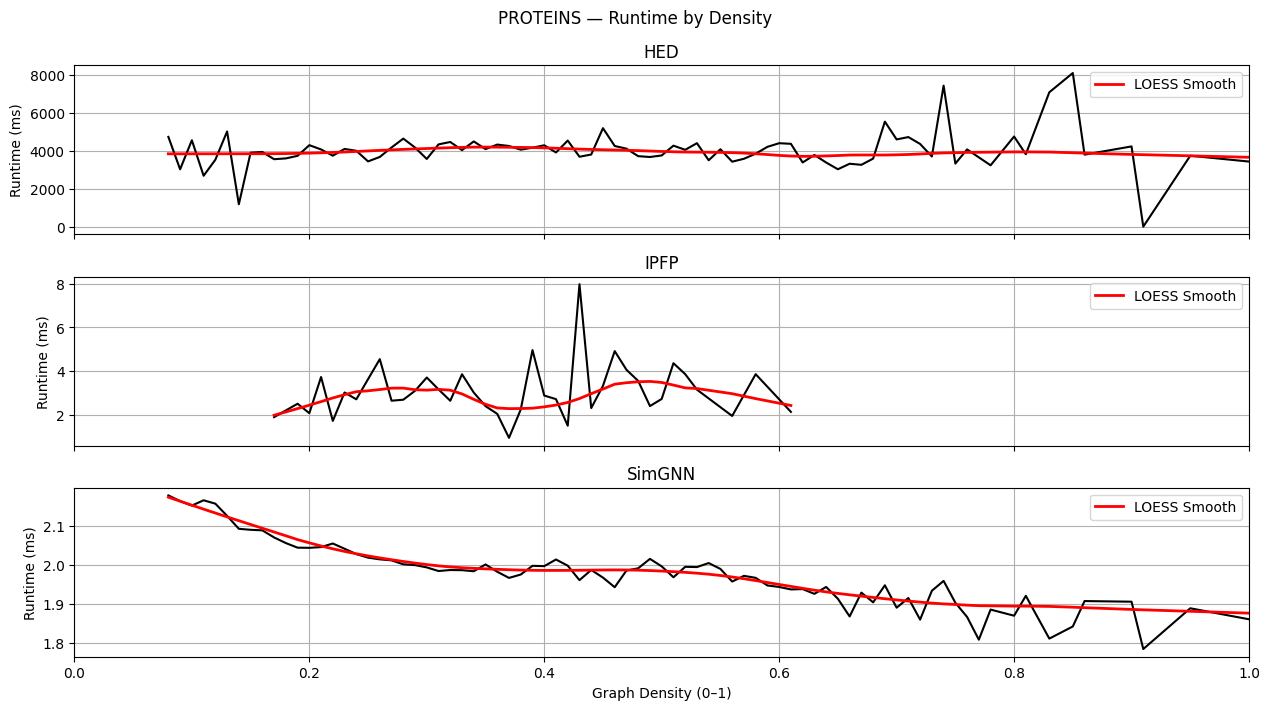

In [31]:
plot_runtime_by_density("PROTEINS")

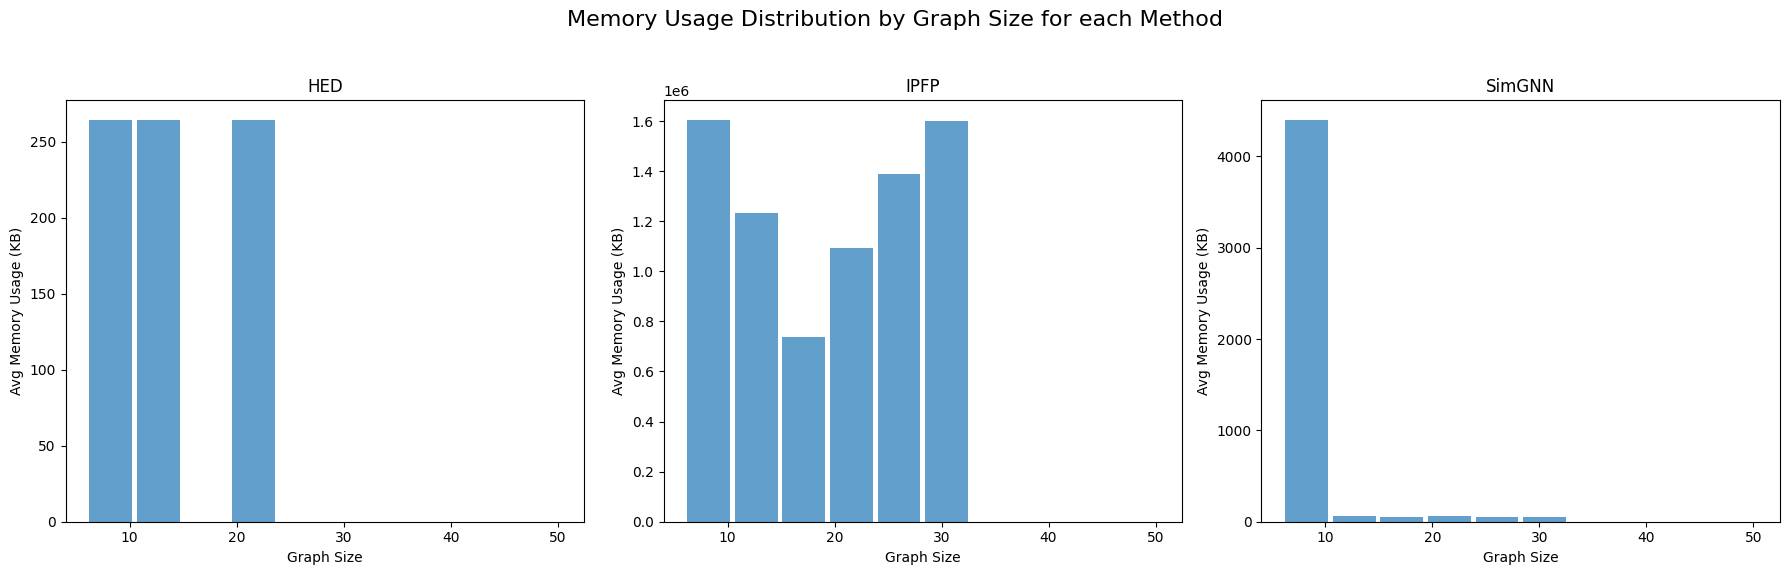

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_memory_histograms_by_method(datasets, bins=10):
    """
    For each dataset, merge each method's memory usage data with SimGNN's graph_size.
    The data is aggregated across datasets for each method and binned by graph_size
    to compute the average memory usage (in KB) per bin. Then, a figure with three
    subplots (one per method) is created showing the memory distribution as a function
    of graph size.
    """
    methods = ["HED", "IPFP", "SimGNN"]
    # Use lists to collect data for each method to avoid concatenating with empty DataFrames
    data_by_method = {method: [] for method in methods}
    all_graph_sizes = []

    for dset in datasets:
        # Use SimGNN's graph_size as reference
        df_simgnn = data[dset]["SimGNN"][["graph_id_1", "graph_id_2", "graph_size"]].copy()
        df_simgnn.dropna(subset=["graph_size"], inplace=True)
        if df_simgnn.empty:
            continue

        for method in methods:
            df_method = data[dset][method].copy()
            df_merged = pd.merge(
                df_method,
                df_simgnn,
                on=["graph_id_1", "graph_id_2"],
                how="left",
                suffixes=("", "_simgnn")
            )
            # Use SimGNN's graph_size
            df_merged["graph_size"] = df_merged["graph_size_simgnn"]
            df_merged.drop(columns=["graph_size_simgnn"], inplace=True, errors="ignore")

            # Filter out rows with missing or zero memory usage and missing graph_size
            df_merged = df_merged.dropna(subset=["memory_usage_mb", "graph_size"])
            df_merged = df_merged[df_merged["memory_usage_mb"] > 0]
            if df_merged.empty:
                continue

            # Convert memory usage from MB to KB
            df_merged["memory_usage_kb"] = df_merged["memory_usage_mb"] * 1024.0

            # Append the relevant columns to our list for this method
            data_by_method[method].append(df_merged[["graph_size", "memory_usage_kb"]])
            all_graph_sizes.extend(df_merged["graph_size"].tolist())

    if not all_graph_sizes:
        print("No valid data found.")
        return

    # Concatenate the lists into DataFrames for each method
    for method in methods:
        if data_by_method[method]:
            data_by_method[method] = pd.concat(data_by_method[method], ignore_index=True)
        else:
            data_by_method[method] = pd.DataFrame(columns=["graph_size", "memory_usage_kb"])

    # Define a common binning based on the global graph_size range
    global_min = min(all_graph_sizes)
    global_max = max(all_graph_sizes)
    bin_edges = np.linspace(global_min, global_max, bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    bar_width = (bin_edges[1] - bin_edges[0]) * 0.9  # Use 90% of bin width for bars

    # Create a figure with one subplot per method
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=100)

    for ax, method in zip(axs, methods):
        df_method = data_by_method[method]
        if df_method.empty:
            ax.text(0.5, 0.5, f'No data for {method}',
                    horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(method)
            continue

        # Bin the data by graph_size using left-closed intervals
        df_method['bin'] = pd.cut(df_method['graph_size'], bins=bin_edges, include_lowest=True, right=False)
        # Group by the bins; explicitly pass observed=False to avoid a FutureWarning
        avg_memory = df_method.groupby('bin', observed=False)['memory_usage_kb'].mean()

        # Create expected bins with left-closed intervals to match pd.cut above
        expected_bins = pd.IntervalIndex.from_breaks(bin_edges, closed='left')
        avg_memory = avg_memory.reindex(expected_bins, fill_value=0)

        # Plot the histogram as a bar chart
        ax.bar(bin_centers, avg_memory.values, width=bar_width, align='center', alpha=0.7)
        ax.set_title(method)
        ax.set_xlabel("Graph Size")
        ax.set_ylabel("Avg Memory Usage (KB)")

    fig.suptitle("Memory Usage Distribution by Graph Size for each Method", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Example usage with the three datasets:
plot_memory_histograms_by_method(["AIDS", "IMDB-BINARY", "PROTEINS"])


In [33]:
import pandas as pd

datasets = ["AIDS", "IMDB-BINARY", "PROTEINS"]
methods = ["HED", "IPFP", "SimGNN"]

for dset in datasets:
    print(f"Dataset: {dset}")
    for method in methods:
        df_method = data[dset][method]

        # Filter out rows where memory_usage_mb is missing or zero
        df_valid = df_method[df_method["memory_usage_mb"].notnull() & (df_method["memory_usage_mb"] > 0)]

        if df_valid.empty:
            print(f"  {method}: No valid memory usage data.")
        else:
            # Convert memory usage from MB to KB
            memory_usage_kb = df_valid["memory_usage_mb"]
            mean_memory_kb = memory_usage_kb.mean()
            max_memory_kb = memory_usage_kb.max()
            print(f"  {method}: Mean Memory Usage = {mean_memory_kb:.2f} MB, Highest Memory Usage = {max_memory_kb:.2f} MB")


Dataset: AIDS
  HED: Mean Memory Usage = 0.26 MB, Highest Memory Usage = 0.26 MB
  IPFP: Mean Memory Usage = 1567.03 MB, Highest Memory Usage = 1580.18 MB
  SimGNN: Mean Memory Usage = 0.02 MB, Highest Memory Usage = 0.07 MB
Dataset: IMDB-BINARY
  HED: Mean Memory Usage = 0.26 MB, Highest Memory Usage = 0.26 MB
  IPFP: Mean Memory Usage = 41.43 MB, Highest Memory Usage = 47.16 MB
  SimGNN: Mean Memory Usage = 0.05 MB, Highest Memory Usage = 0.45 MB
Dataset: PROTEINS
  HED: Mean Memory Usage = 0.26 MB, Highest Memory Usage = 0.26 MB
  IPFP: No valid memory usage data.
  SimGNN: Mean Memory Usage = 4.43 MB, Highest Memory Usage = 10.72 MB


In [34]:
def plot_runtime_by_node_diversity(dset, df_diversities, num_bins=20):
    """
    Plots the runtime (in ms) vs. node diversity for each method (HED, IPFP, SimGNN).
    For each method, the function merges runtime with node diversity, bins the diversity values,
    computes the average runtime (in ms) for each bin, plots the binned averages as a black line,
    and overlays a LOESS smooth curve (red) to illustrate the trend.
    """
    methods = ["HED", "IPFP", "SimGNN"]
    fig, axes = plt.subplots(nrows=len(methods), figsize=(12.8, 7.2), sharex=True, dpi=120)
    if len(methods) == 1:
        axes = [axes]

    for i, method in enumerate(methods):
        # Merge method runtime data with node diversity
        df_merged = get_df_with_diversities(dset, method, df_diversities)
        # Keep rows with valid runtime and diversity values, and filter to reasonable runtime range (e.g. 0–6 sec)
        df_merged = df_merged.dropna(subset=["runtime", "node_labels"])
        df_merged = df_merged[(df_merged["runtime"] > 0) & (df_merged["runtime"] < 6)]
        if df_merged.empty:
            axes[i].text(0.5, 0.5, f"No data for {method}",
                         ha='center', va='center', transform=axes[i].transAxes)
            continue
        # Convert runtime to milliseconds
        df_merged["runtime_ms"] = df_merged["runtime"] * 1000

        # Bin the node diversity values into num_bins bins
        bins = np.linspace(df_merged["node_labels"].min(), df_merged["node_labels"].max(), num_bins+1)
        df_merged["node_div_bin"] = pd.cut(df_merged["node_labels"], bins=bins, include_lowest=True)
        # Group by the binned diversity and compute the average runtime
        grouped = df_merged.groupby("node_div_bin")["runtime_ms"].mean().reset_index()
        # Compute bin centers for plotting
        grouped["bin_center"] = grouped["node_div_bin"].apply(lambda x: x.left + (x.right - x.left)/2)

        # Plot the binned average runtime as a black line (or scatter if only one bin)
        if grouped["bin_center"].nunique() > 1:
            axes[i].plot(grouped["bin_center"], grouped["runtime_ms"], color="black", label="Binned Avg")
        else:
            axes[i].scatter(grouped["bin_center"], grouped["runtime_ms"], color="black", label="Binned Avg")

        # Add LOESS smooth curve if there are multiple x-values
        if grouped["bin_center"].nunique() > 1:
            x_vals = grouped["bin_center"].values
            y_vals = grouped["runtime_ms"].values
            loess_smoothed = lowess(endog=y_vals, exog=x_vals, frac=0.3)
            axes[i].plot(loess_smoothed[:, 0], loess_smoothed[:, 1],
                         color="red", linewidth=2, label="LOESS Smooth")

        axes[i].set_title(f"{method}")
        axes[i].set_ylabel("Runtime (ms)")
        axes[i].grid(True)
        axes[i].legend(loc="best")

    axes[-1].set_xlabel("Node Diversity")
    fig.suptitle(f"{dset} — Runtime by Node Diversity")
    plt.tight_layout()
    plt.show()

def plot_runtime_by_edge_diversity(dset, df_diversities, num_bins=20):
    """
    Plots the runtime (in ms) vs. edge diversity for each method (HED, IPFP, SimGNN).
    For each method, the function merges runtime with edge diversity,
    bins the diversity values, computes the average runtime (in ms) for each bin,
    plots the binned averages as a black line, and overlays a LOESS smooth curve (red)
    to illustrate the trend.
    """
    methods = ["HED", "IPFP", "SimGNN"]
    fig, axes = plt.subplots(nrows=len(methods), figsize=(12.8, 7.2), sharex=True, dpi=120)
    if len(methods) == 1:
        axes = [axes]

    for i, method in enumerate(methods):
        # Merge method runtime data with edge diversity
        df_merged = get_df_with_diversities(dset, method, df_diversities)
        # Keep rows with valid runtime and edge diversity values, and filter to reasonable runtime range
        df_merged = df_merged.dropna(subset=["runtime", "edge_labels"])
        df_merged = df_merged[(df_merged["runtime"] > 0) & (df_merged["runtime"] < 6)]
        if df_merged.empty:
            axes[i].text(0.5, 0.5, f"No data for {method}",
                         ha='center', va='center', transform=axes[i].transAxes)
            continue
        # Convert runtime to milliseconds
        df_merged["runtime_ms"] = df_merged["runtime"] * 1000

        # Bin the edge diversity values into num_bins bins
        bins = np.linspace(df_merged["edge_labels"].min(), df_merged["edge_labels"].max(), num_bins+1)
        df_merged["edge_div_bin"] = pd.cut(df_merged["edge_labels"], bins=bins, include_lowest=True)
        # Group by the binned diversity and compute the average runtime
        grouped = df_merged.groupby("edge_div_bin")["runtime_ms"].mean().reset_index()
        # Compute bin centers for plotting
        grouped["bin_center"] = grouped["edge_div_bin"].apply(lambda x: x.left + (x.right - x.left)/2)

        # Plot the binned average runtime as a black line (or scatter if only one bin)
        if grouped["bin_center"].nunique() > 1:
            axes[i].plot(grouped["bin_center"], grouped["runtime_ms"], color="black", label="Binned Avg")
        else:
            axes[i].scatter(grouped["bin_center"], grouped["runtime_ms"], color="black", label="Binned Avg")

        # Add LOESS smooth curve if there are multiple x-values
        if grouped["bin_center"].nunique() > 1:
            x_vals = grouped["bin_center"].values
            y_vals = grouped["runtime_ms"].values
            loess_smoothed = lowess(endog=y_vals, exog=x_vals, frac=0.3)
            axes[i].plot(loess_smoothed[:, 0], loess_smoothed[:, 1],
                         color="red", linewidth=2, label="LOESS Smooth")

        axes[i].set_title(f"{method}")
        axes[i].set_ylabel("Runtime (ms)")
        axes[i].grid(True)
        axes[i].legend(loc="best")

    axes[-1].set_xlabel("Edge Diversity")
    fig.suptitle(f"{dset} — Runtime by Edge Diversity")
    plt.tight_layout()
    plt.show()


In [35]:
# Choose a dataset to plot
dataset_name = "AIDS"

# Load the node/edge label diversities
table_dir = r"C:\project_data\results\label_diversity"
file_1 = os.path.join(table_dir, f"{dataset_name}_node_edge_label_diversities_part1.xlsx")
file_2 = os.path.join(table_dir, f"{dataset_name}_node_edge_label_diversities_part2.xlsx")

# Read the two partial Excel files, forcing graph_id columns to string
df_part1 = pd.read_excel(file_1, dtype={"graph_id_1": str, "graph_id_2": str})
df_part2 = pd.read_excel(file_2, dtype={"graph_id_1": str, "graph_id_2": str})

# Concatenate them into a single DataFrame
df_diversities_merged = pd.concat([df_part1, df_part2], ignore_index=True)

C:\Users\mikef\AppData\Local\Temp\ipykernel_23324\4156514486.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_merged.groupby("node_div_bin")["runtime_ms"].mean().reset_index()
C:\Users\mikef\AppData\Local\Temp\ipykernel_23324\4156514486.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_merged.groupby("node_div_bin")["runtime_ms"].mean().reset_index()
C:\Users\mikef\AppData\Local\Temp\ipykernel_23324\4156514486.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

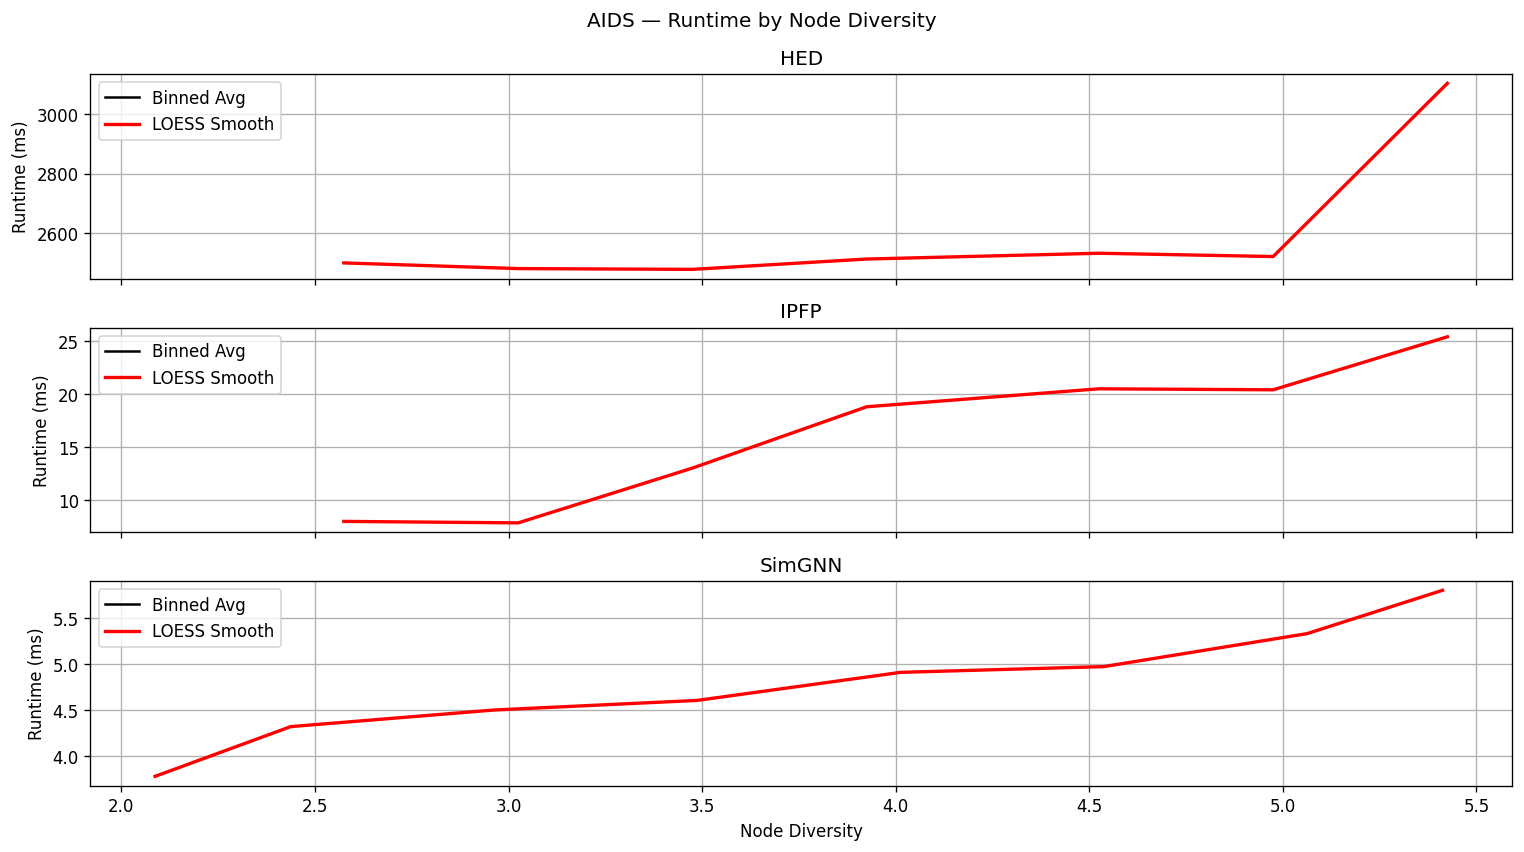

In [36]:
plot_runtime_by_node_diversity(dataset_name, df_diversities_merged)

C:\Users\mikef\AppData\Local\Temp\ipykernel_23324\4156514486.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_merged.groupby("edge_div_bin")["runtime_ms"].mean().reset_index()
C:\Users\mikef\AppData\Local\Temp\ipykernel_23324\4156514486.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_merged.groupby("edge_div_bin")["runtime_ms"].mean().reset_index()
C:\Users\mikef\AppData\Local\Temp\ipykernel_23324\4156514486.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

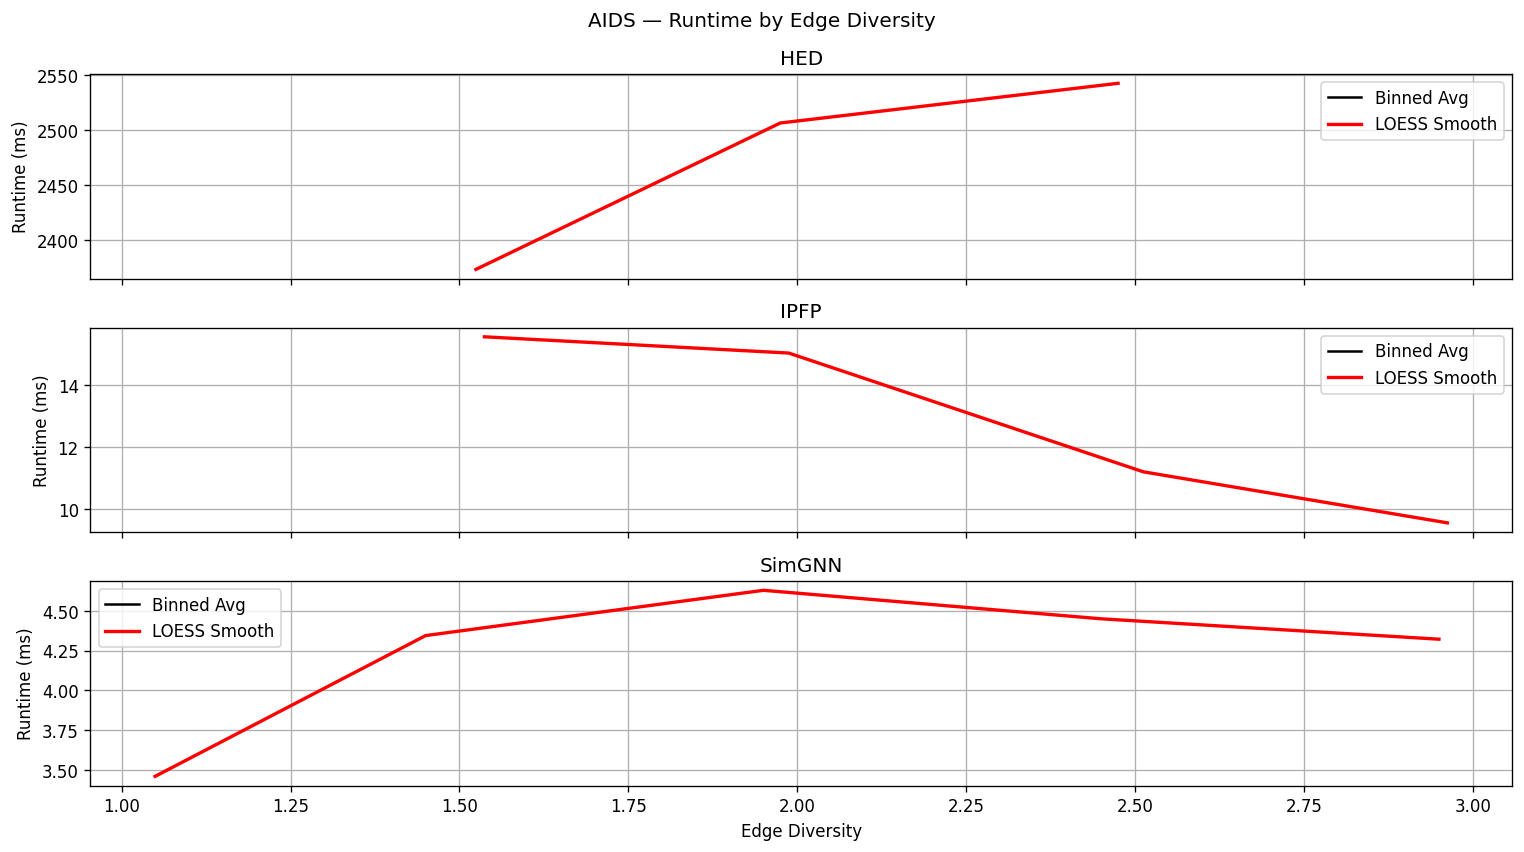

In [37]:
plot_runtime_by_edge_diversity(dataset_name, df_diversities_merged)